In [1]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold,StratifiedKFold,train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics

In [2]:
def plot_confusion_matrix(true,predicted,save_fig=False,title=None):
    import itertools
    sns.set(color_codes=True)
    sns.set(rc={'figure.figsize':(12,10)})
    cm=confusion_matrix(true,predicted)
    classes=['Home Team Loss','Home Team Win']
    
    fig = plt.figure(figsize=(14,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm,cmap=plt.cm.Blues)
    #plt.title('Confusion matrix',fontdict={'size':20})
    fig.colorbar(cax)
    ax.set_xticklabels([''] + classes,fontdict={'size':14})
    ax.set_yticklabels([''] + classes,fontdict={'size':14})
    plt.xlabel('Predicted',fontdict={'size':14})
    plt.ylabel('True',fontdict={'size':14})
    plt.grid(b=None)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             fontdict={'size':14,'weight':'heavy'},
             color="black" if cm[i, j] > thresh else "black")
    if title:
        plt.title(title,fontdict={'fontsize':16})
    if save_fig:
        plt.savefig(save_fig)
    plt.show()

def pipeline_cv(splits, X, Y, pipeline, average_method=None):
    
    kfold = KFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    roc_auc_scores = []
    for train, test in kfold.split(X, Y):
        fit = pipeline.fit(X.iloc[train], Y[train])
        prediction = fit.predict(X.iloc[test])
        
        scores = fit.score(X.iloc[test],Y[test])
        
        display(pd.DataFrame(metrics.classification_report(Y[test],prediction,output_dict=True)))
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction)*100)
        
        #print('precision:',precision_score(Y[test], prediction))
        recall.append(recall_score(Y[test], prediction)*100)
        #print('recall:   ',recall_score(Y[test], prediction))
        f1.append(f1_score(Y[test], prediction)*100)
        #print('f1 score: ',f1_score(Y[test], prediction))
        #print('-'*50)
        
        roc_auc_scores.append(roc_auc_score(Y[test],prediction)*100)
        
        plot_confusion_matrix(Y[test],prediction)
        
        

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))
    print("roc_auc score: %.2f%% (+/- %.2f%%)" % (np.mean(roc_auc_scores), np.std(roc_auc_scores)))
    

In [3]:
import config
import sqlalchemy
import functions
import statsapi as mlb
import sql_alch_schema
from datetime import datetime

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String,DateTime,Date,Time,Boolean,func
from sqlalchemy import ForeignKey,and_
from sqlalchemy.orm import relationship
from sqlalchemy.schema import Table
from sqlalchemy import distinct

_sql_alchemy_connection = (
                                f'mysql+mysqlconnector://'
                                f'{config.user}:{config.password}'
                                f'@{config.host}:{config.port}'
                                f'/{config.schema}'
                           )
## Create the engine 
db = sqlalchemy.create_engine(_sql_alchemy_connection,
                              echo = False,
                              connect_args = {'ssl_disabled' : True,})

Base = sql_alch_schema.Base

Game = sql_alch_schema.Game
Play = sql_alch_schema.Play
Team = sql_alch_schema.Team
GameTeamLink = sql_alch_schema.GameTeamLink
Person = sql_alch_schema.Person


from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=db)
session = Session()

#Base.metadata.create_all(db)


import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})

extra_features_df=functions.getGame_df()
df=functions.load_dataset(session)

grand_df=pd.merge(left=df,
                  right=extra_features_df,
                  left_on='ID',
                  right_on='id')
grand_df['homeTeam_win']=grand_df.apply(lambda x: 1 if x['home_score']>x['away_score'] else 0,axis=1)
#df['homeTeam_win']=grand_df.apply(lambda x: 1 if x['home_score']>x['away_score'] else 0,axis=1)

In [4]:
def trailing_winPct(row):
    home_wins=(grand_df[
        (grand_df['homeTeam_id']==row['homeTeam_id'])
        &(grand_df['ID']<row['ID'])]
               ['homeTeam_win'].sum())
    
    away_wins=(grand_df[
        (grand_df['awayTeam_id']==row['homeTeam_id'])
        &(grand_df['ID']<row['ID'])
        &(grand_df['homeTeam_win']==0)].shape[0])
    
    total_games=(grand_df[
        ((grand_df['homeTeam_id']==row['homeTeam_id'])|(grand_df['awayTeam_id']==row['homeTeam_id']))
        &(grand_df['ID']<row['ID'])].shape[0])
    return (home_wins+away_wins)/total_games

def away_trailing_winPct(row):
    home_wins=(grand_df[
        (grand_df['homeTeam_id']==row['awayTeam_id'])
        &(grand_df['ID']<row['ID'])]
               ['homeTeam_win'].sum())
    
    away_wins=(grand_df[
        (grand_df['awayTeam_id']==row['awayTeam_id'])
        &(grand_df['ID']<row['ID'])
        &(grand_df['homeTeam_win']==0)].shape[0])
    
    total_games=(grand_df[
        ((grand_df['homeTeam_id']==row['awayTeam_id'])|(grand_df['awayTeam_id']==row['awayTeam_id']))
        &(grand_df['ID']<row['ID'])].shape[0])
    return (home_wins+away_wins)/total_games

df['homeWin_pct']=grand_df.apply(lambda x: trailing_winPct(x),axis=1)

df['awayWin_pct']=grand_df.apply(lambda x: away_trailing_winPct(x),axis=1)
#df.dropna(inplace=True)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars


In [5]:
from sklearn.base import BaseEstimator
class WinPercentageClassifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        preds=X.apply(lambda row: 1 if row['homeWin_pct']>row['awayWin_pct'] else 0,axis=1)
        return preds
    def predict_proba(self,X):
        return np.array(X[['awayWin_pct','homeWin_pct']].fillna(value=.5))
        

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,roc_curve

X=df.drop(columns=['ID','home_score','away_score',])
y=df.apply(lambda x: 1 if x['home_score']>x['away_score'] else 0,axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=12)

dummy = WinPercentageClassifier()

dummy.fit(X_train)
dummy_preds = dummy.predict(X_test)

print(f1_score(y_test,dummy_preds))
dummy_preds.value_counts()


print('dummy f1: ',np.mean(cross_val_score(dummy,X,y,cv=5,scoring='f1')))
print('dummy accuracy: ',np.mean(cross_val_score(dummy,X,y,cv=5,scoring='accuracy')))
print('dummy precision: ',np.mean(cross_val_score(dummy,X,y,cv=5,scoring='precision')))
print('dummy recall: ',np.mean(cross_val_score(dummy,X,y,cv=5,scoring='recall')))

0.5731584258324924
dummy f1:  0.5893040912369256
dummy accuracy:  0.5793405890156091
dummy precision:  0.6082246841898
dummy recall:  0.5717163999240397


In [6]:
from sklearn.base import TransformerMixin

class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self,add_hitters_slashInteraction = True):
        self.add_hitters_slashInteraction=add_hitters_slashInteraction
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        try:
            if self.add_hitters_slashInteraction:
                #X.loc[:,'homeHitter_slashInteraction']=X.apply(lambda row:row['home_hitters_OBP_mean']*row['home_hitters_SLG_mean'],axis=1)
                X.loc[:,'homeHitter_slashInteraction'] = (X.loc[:,'home_hitters_OBP_mean']
                                               *X.loc[:,'home_hitters_SLG_mean']
                                               *X.loc[:,'home_hitters_BA_mean'])
                X.loc[:,'awayHitter_slashInteraction'] = (X.loc[:,'away_hitters_OBP_mean']
                                               *X.loc[:,'away_hitters_SLG_mean']
                                               *X.loc[:,'away_hitters_BA_mean'])


                return X 
        except:
            X['homeHitter_slashInteraction'] = X.apply(lambda row: row['home_hitters_OBP_mean']
                                                      *row['home_hitters_SLG_mean']
                                                      *row['home_hitters_BA_mean'])
            X['awayHitter_slashInteraction'] = X.apply(lambda row: row['away_hitters_OBP_mean']
                                                      *row['away_hitters_SLG_mean']
                                                      *row['away_hitters_BA_mean'])
            return X
        else:
            pass


In [7]:
pd.options.mode.chained_assignment=None

In [8]:
import joblib
model_path = "/Users/schlinkertc/code/mlb_predictions/mlb_predictions/models/"

stacking_clf=joblib.load(model_path+'stacking_clf.pkl')
lr_l1 = joblib.load(model_path+'lr_l1.pkl')
lr_clf = stacking_clf.estimators[0][1]
rf_65 = joblib.load(model_path+'rf_65.pkl')
rf_clf=stacking_clf.estimators[1][1]

In [9]:
models = [rf_65,lr_clf,dummy]

In [10]:
for model in models:
    model.fit(X,y)

In [11]:
image_dir = "/Users/schlinkertc/code/mlb_predictions/mlb_predictions/images/"

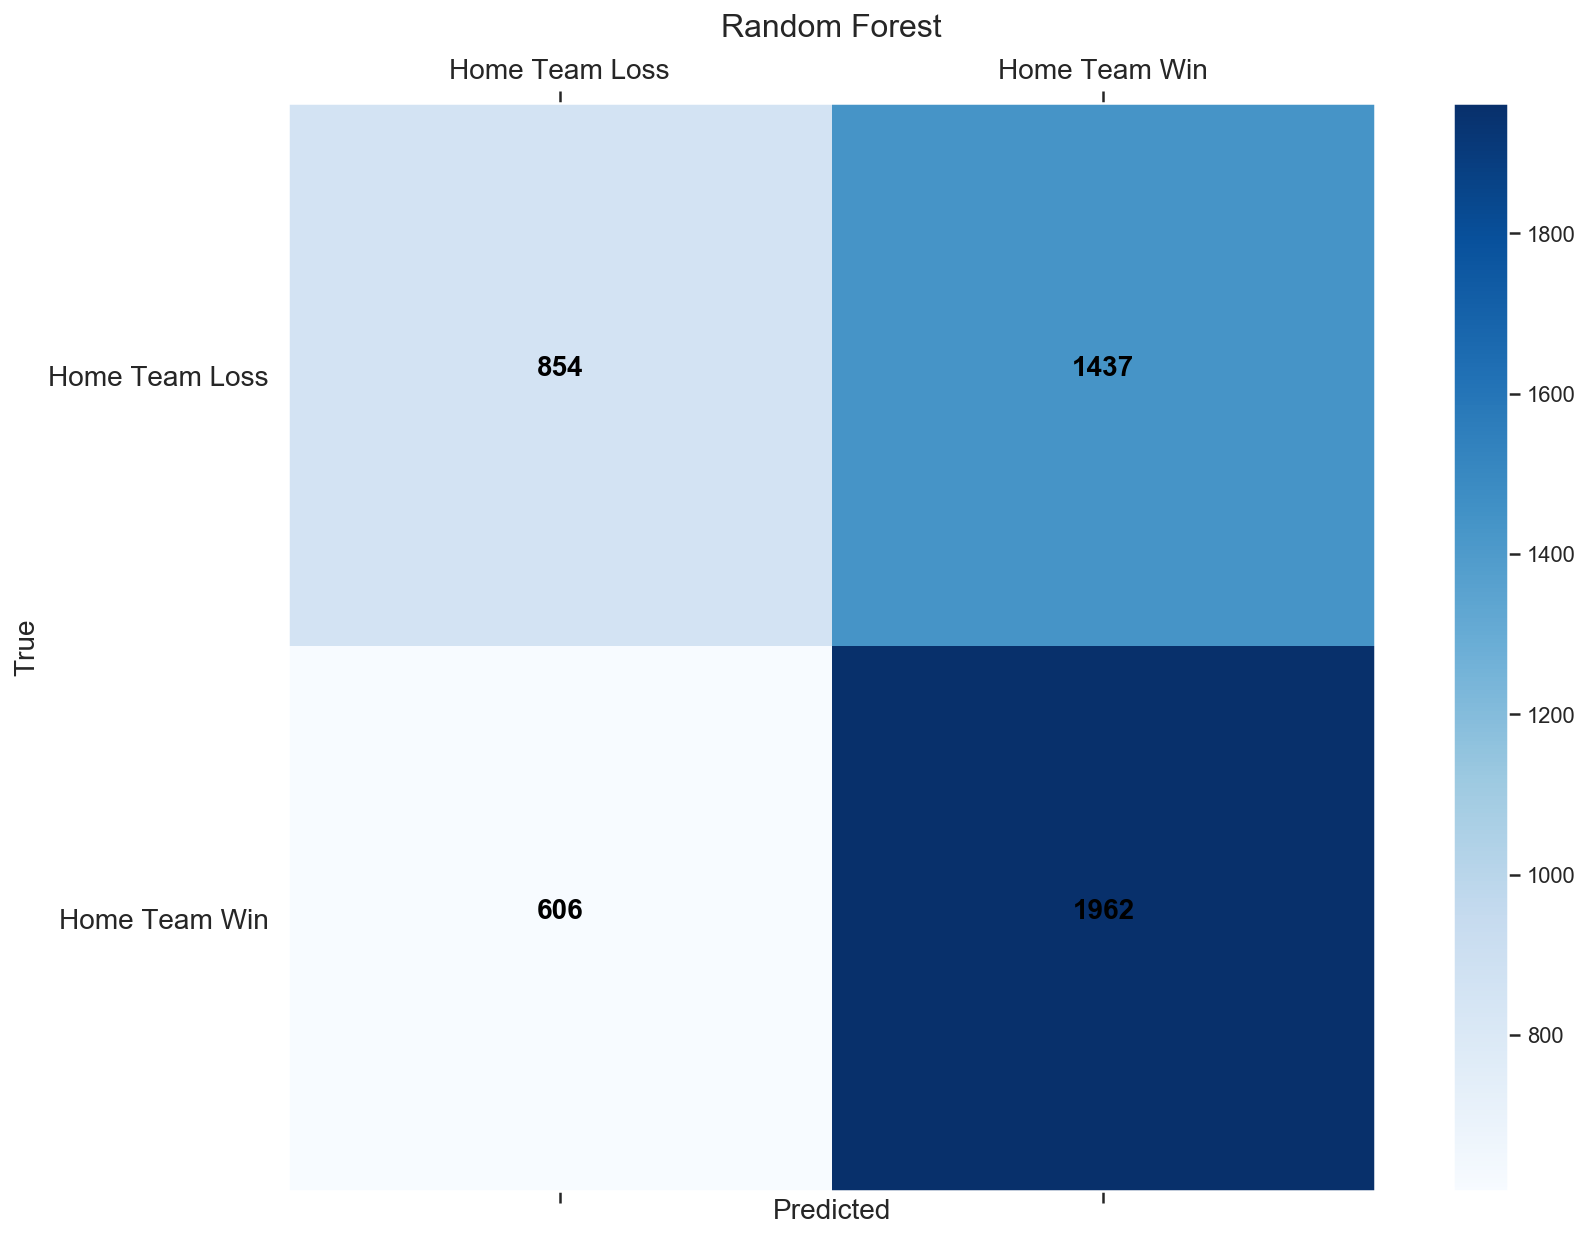

In [12]:
plot_confusion_matrix(y,rf_65.predict(X),save_fig=image_dir+'RF_confusionMatrix',title='Random Forest')

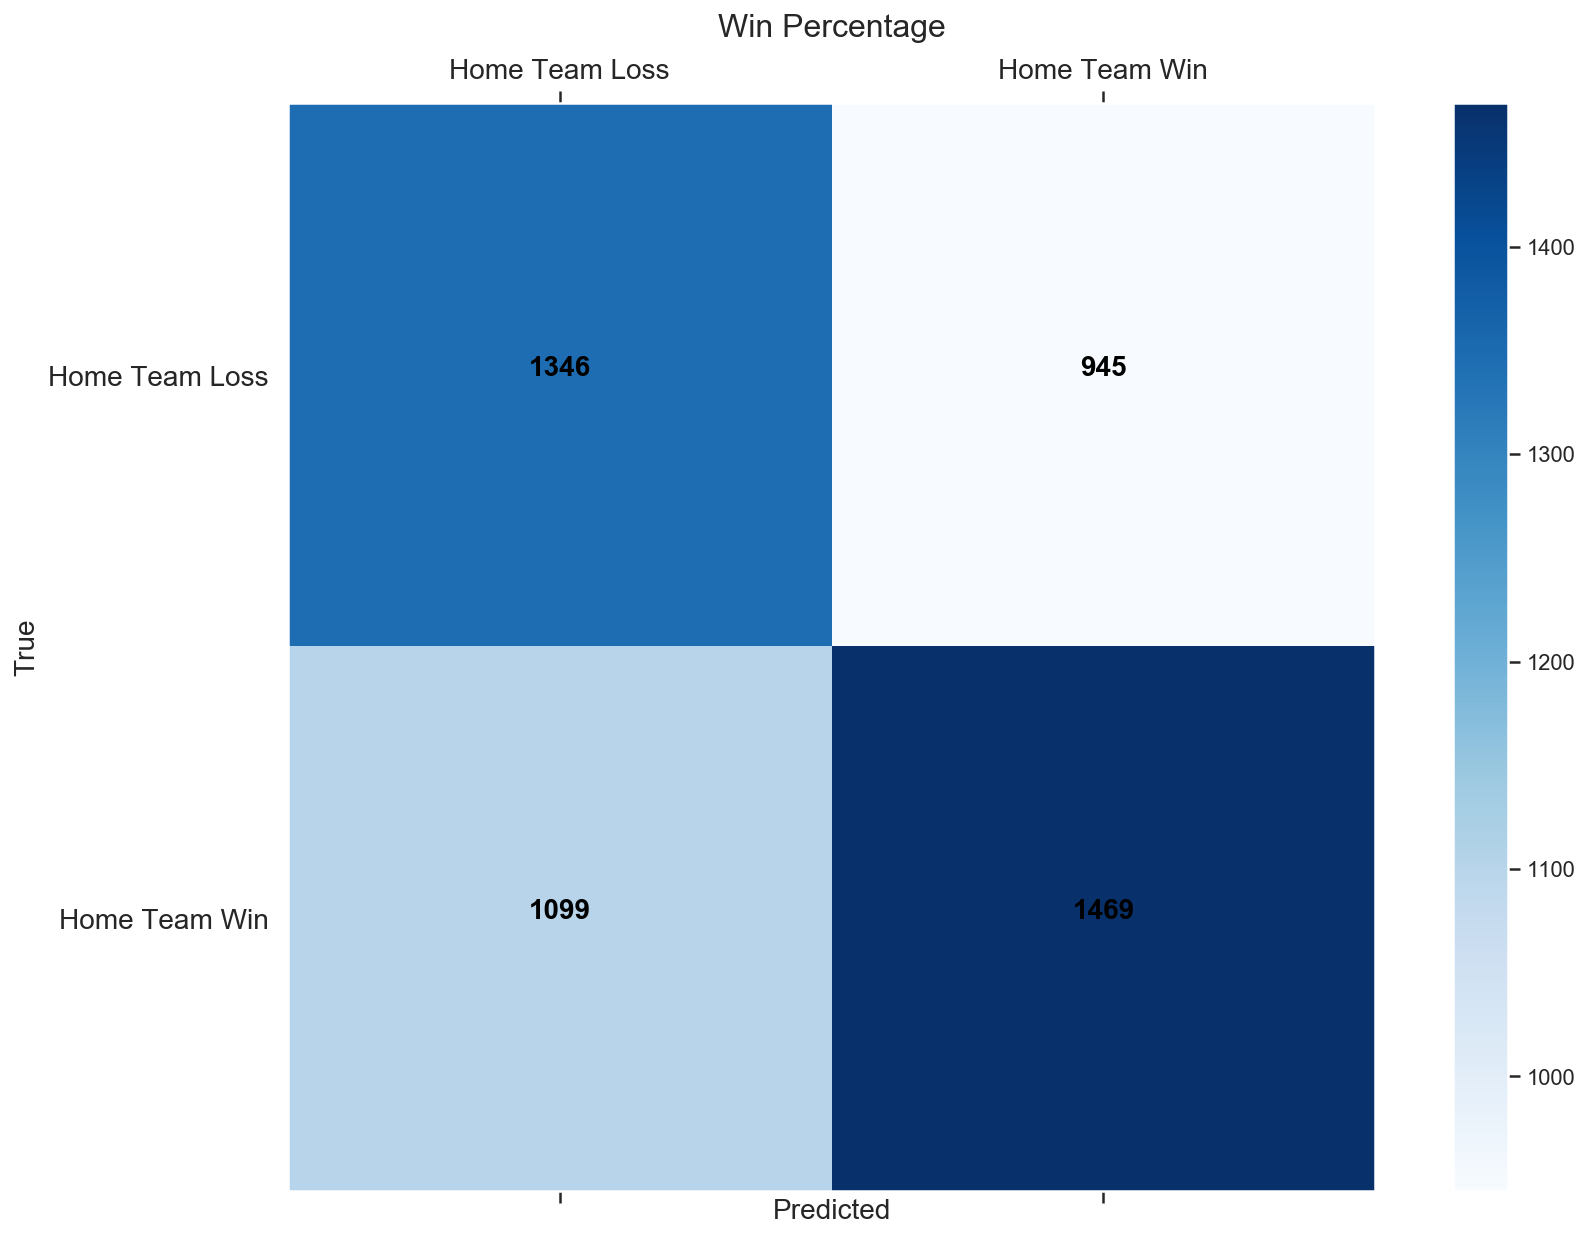

In [13]:
plot_confusion_matrix(y,dummy.predict(X),save_fig=image_dir+'dummy',title='Win Percentage')

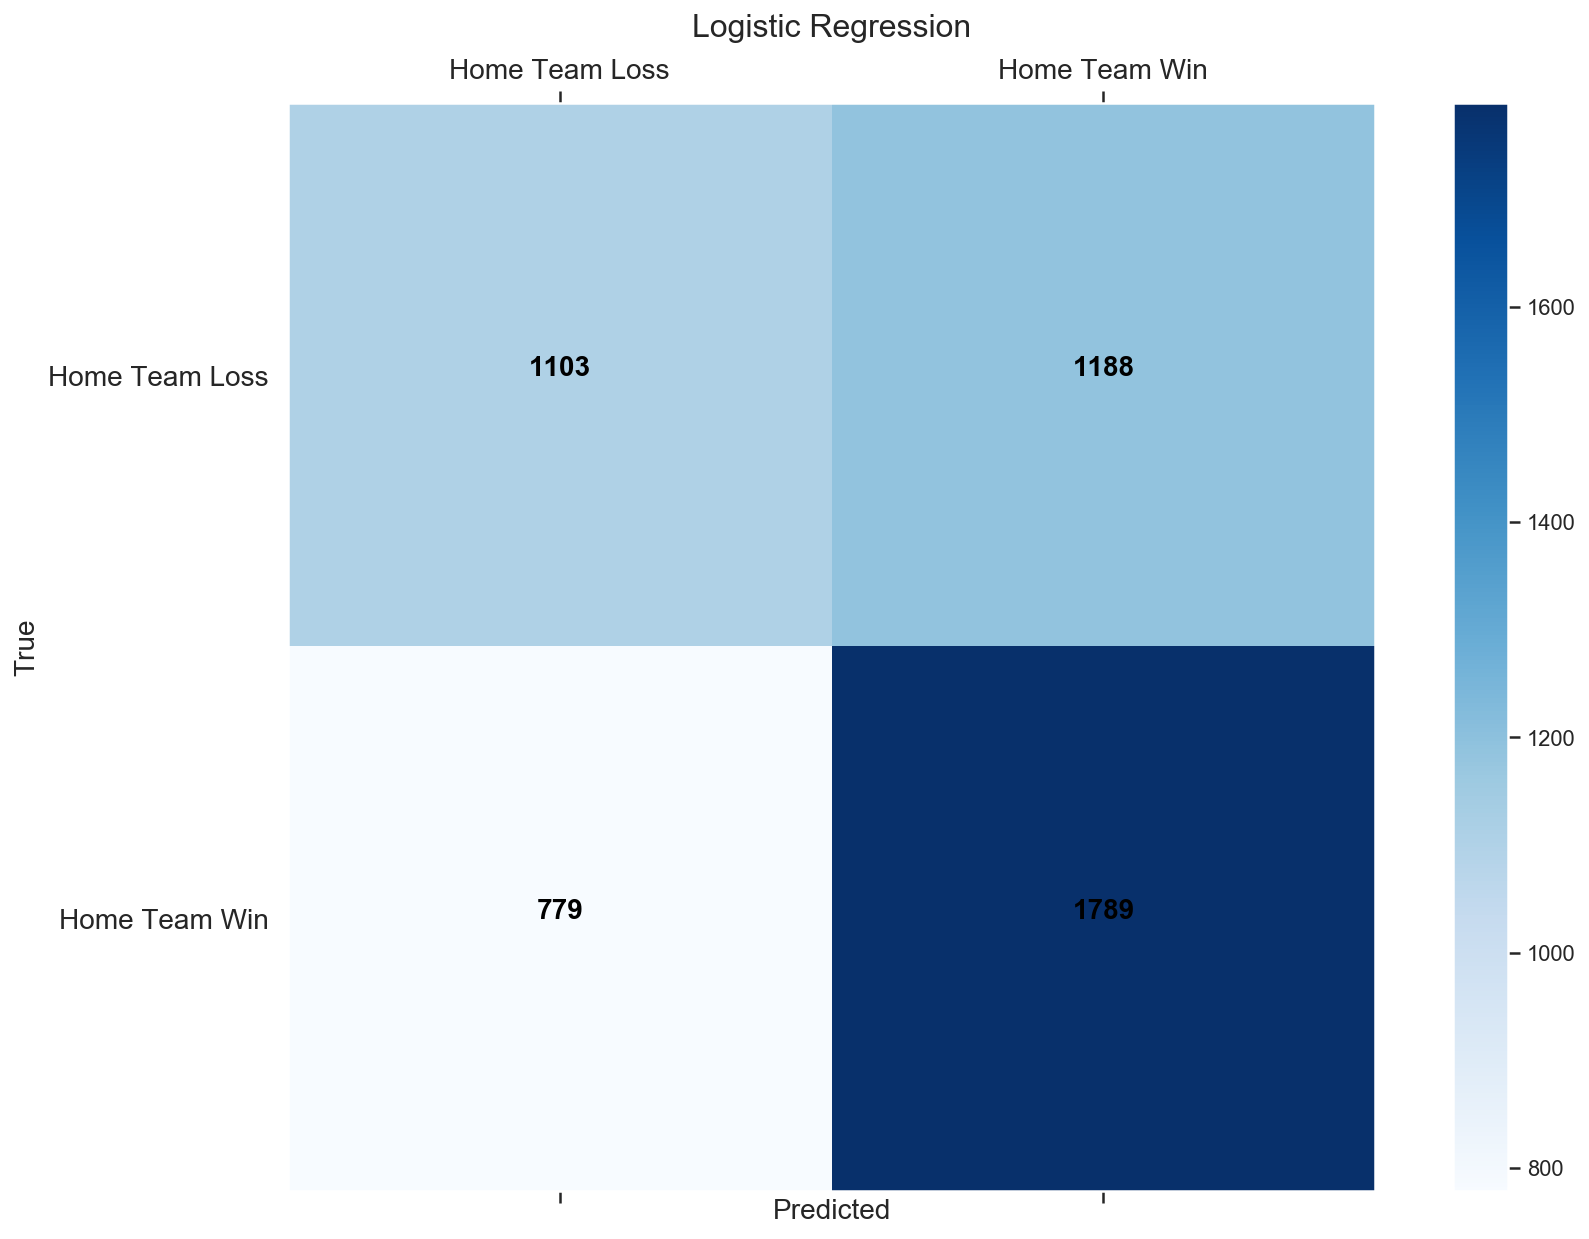

In [14]:
plot_confusion_matrix(y,lr_clf.predict(X),save_fig=image_dir+'Logistic_Regression',title='Logistic Regression')

In [15]:
f1_score(y,np.ones(len(y)))

0.69153090076747

In [16]:
print([f1_score(y,model.predict(X))for model in models])
print([precision_score(y,model.predict(X))for model in models])
print([roc_auc_score(y,model.predict(X))for model in models])

[0.6576168929110106, 0.6452660054102796, 0.5897230028101165]
[0.5772285966460724, 0.6009405441719852, 0.6085335542667771]
[0.5683908385922973, 0.5890501195929896, 0.5797784334202235]


In [17]:
from sklearn.model_selection import KFold
kfold=KFold(n_splits=5,random_state=12,shuffle=True)

In [18]:
from sklearn.metrics import roc_auc_score,accuracy_score

In [19]:
f1_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
auc_scores = []

for model in models:
    for train, test in kfold.split(X, y):
        model_f1s = []
        model_accuracies = []
        model_precisions = []
        model_recalls = []
        model_aucs = []
        fit = model.fit(X.iloc[train], y[train])
        prediction = fit.predict(X.iloc[test])
        
        
        f1 = f1_score(y[test],prediction)
        accuracy = metrics.accuracy_score(y[test],prediction)
        precision = precision_score(y[test],prediction)
        recall = recall_score(y[test],prediction)
        auc= roc_auc_score(y[test],prediction)
        
        model_f1s.append(f1)
        model_accuracies.append(accuracy)
        model_precisions.append(precision)
        model_recalls.append(recall)
        model_aucs.append(auc)
    try:
        f1_scores.append(
            {'model':model['classifier'].__repr__().split('(')[0],
             'mean_f1':np.mean(model_f1s)})
        accuracy_scores.append(
            {'model':model['classifier'].__repr__().split('(')[0],
             'mean_accuracy':np.mean(model_accuracies)})
        
        precision_scores.append(
            {'model':model['classifier'].__repr__().split('(')[0],
             'mean_precision':np.mean(model_precisions)})
        
        recall_scores.append(
            {'model':model['classifier'].__repr__().split('(')[0],
             'mean_recall':np.mean(model_recalls)})
        auc_scores.append(
            {'model':model['classifier'].__repr__().split('(')[0],
             'mean_auc':np.mean(model_aucs)})
        
    except:
        f1_scores.append(
            {'model':model.__repr__().split('(')[0],
             'mean_f1':np.mean(model_f1s)})
        accuracy_scores.append(
            {'model':model.__repr__().split('(')[0],
             'mean_accuracy':np.mean(model_accuracies)})
        
        precision_scores.append(
            {'model':model.__repr__().split('(')[0],
             'mean_precision':np.mean(model_precisions)})
        
        recall_scores.append(
            {'model':model.__repr__().split('(')[0],
             'mean_recall':np.mean(model_recalls)})
        
        auc_scores.append(
            {'model':model.__repr__().split('(')[0],
             'mean_auc':np.mean(model_aucs)})
        f1_scores.append({'model':'Dummy','mean_f1':f1_score(y,np.ones(len(y)))})
        accuracy_scores.append({'model':'Dummy','mean_accuracy':accuracy_score(y,np.ones(len(y)))})
        recall_scores.append({'model':'Dummy','mean_recall':recall_score(y,np.ones(len(y)))})
        precision_scores.append({'model':'Dummy','mean_precision':precision_score(y,np.ones(len(y)))})
        auc_scores.append({'model':'Dummy','mean_auc':roc_auc_score(y,np.ones(len(y)))})
        

In [20]:
for model in models:
    f1_score

In [21]:
f1_scores

[{'model': 'RandomForestClassifier', 'mean_f1': 0.6774193548387096},
 {'model': 'LogisticRegression', 'mean_f1': 0.6241920590951061},
 {'model': 'WinPercentageClassifier', 'mean_f1': 0.5717277486910995},
 {'model': 'Dummy', 'mean_f1': 0.69153090076747}]

In [22]:
accuracy_scores

[{'model': 'RandomForestClassifier', 'mean_accuracy': 0.588053553038105},
 {'model': 'LogisticRegression', 'mean_accuracy': 0.5808444902162719},
 {'model': 'WinPercentageClassifier', 'mean_accuracy': 0.5787847579814624},
 {'model': 'Dummy', 'mean_accuracy': 0.5285038073677711}]

In [23]:
recall_scores

[{'model': 'RandomForestClassifier', 'mean_recall': 0.8187134502923976},
 {'model': 'LogisticRegression', 'mean_recall': 0.6588693957115009},
 {'model': 'WinPercentageClassifier', 'mean_recall': 0.5321637426900585},
 {'model': 'Dummy', 'mean_recall': 1.0}]

In [24]:
precision_scores

[{'model': 'RandomForestClassifier', 'mean_precision': 0.5777166437414031},
 {'model': 'LogisticRegression', 'mean_precision': 0.5929824561403508},
 {'model': 'WinPercentageClassifier', 'mean_precision': 0.6176470588235294},
 {'model': 'Dummy', 'mean_precision': 0.5285038073677711}]

In [25]:
auc_scores

[{'model': 'RandomForestClassifier', 'mean_auc': 0.5742038867182513},
 {'model': 'LogisticRegression', 'mean_auc': 0.5761595886854448},
 {'model': 'WinPercentageClassifier', 'mean_auc': 0.5815840547511428},
 {'model': 'Dummy', 'mean_auc': 0.5}]

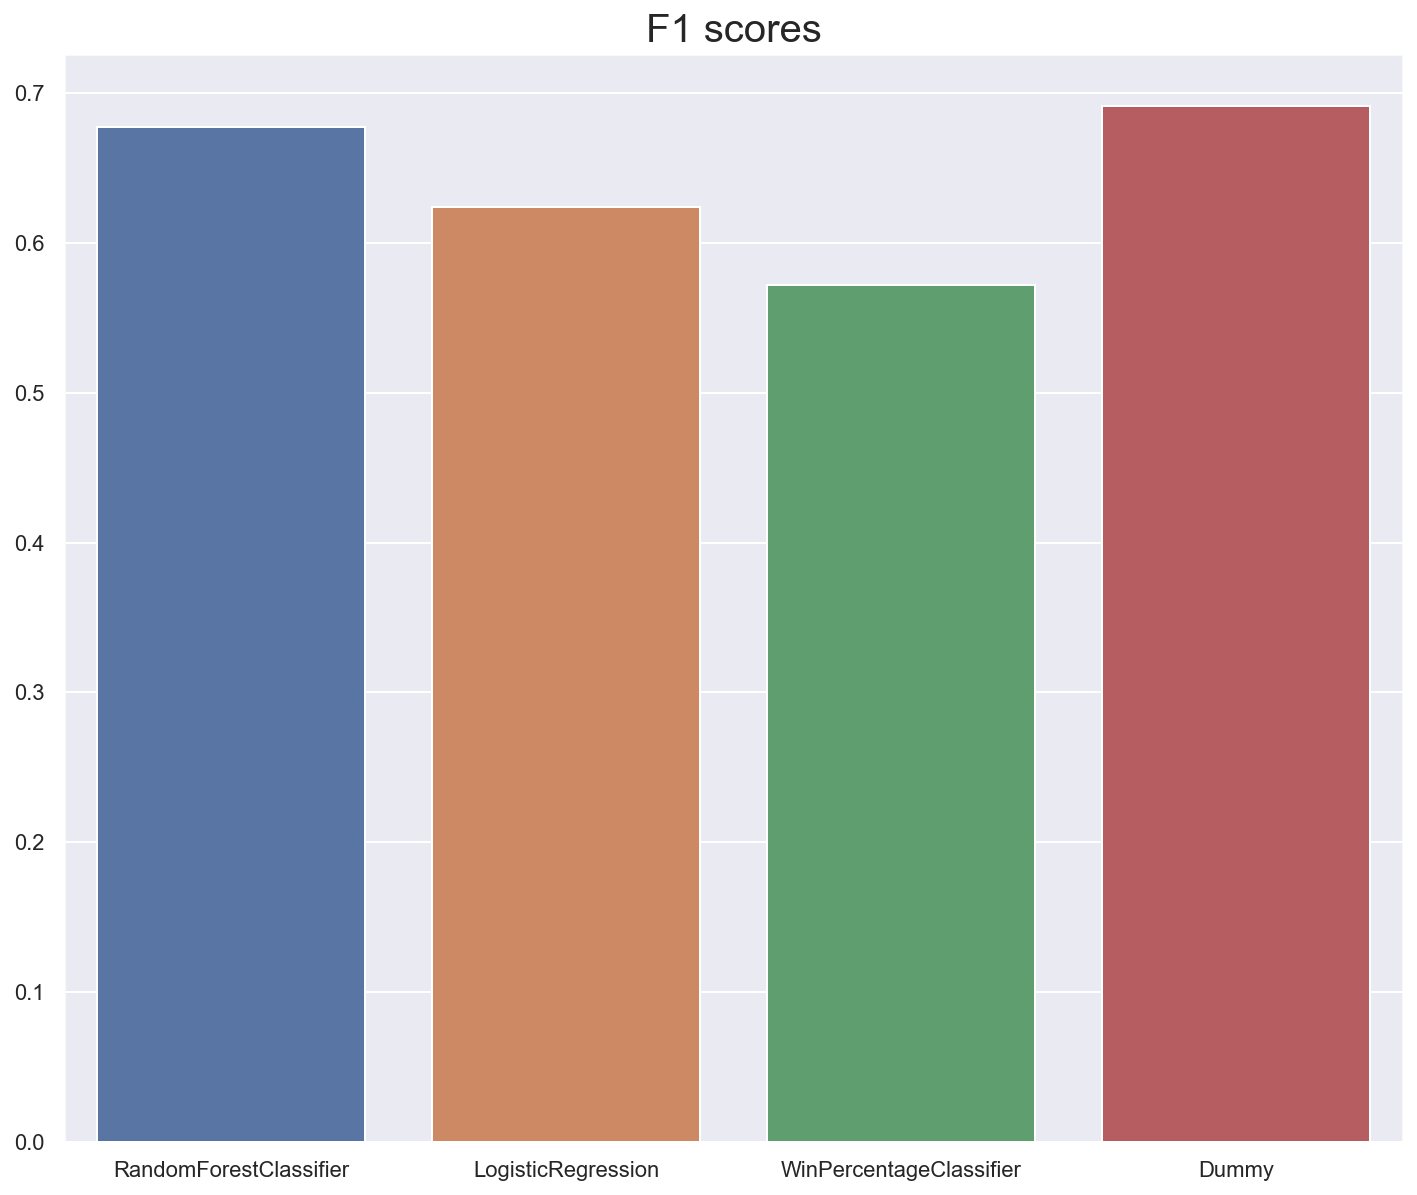

In [26]:
sns.barplot([x['model'] for x in f1_scores],[x['mean_f1']for x in f1_scores])
plt.title('F1 scores',fontdict={'fontsize':20})
plt.savefig(image_dir+'f1.jpg')
plt.show()

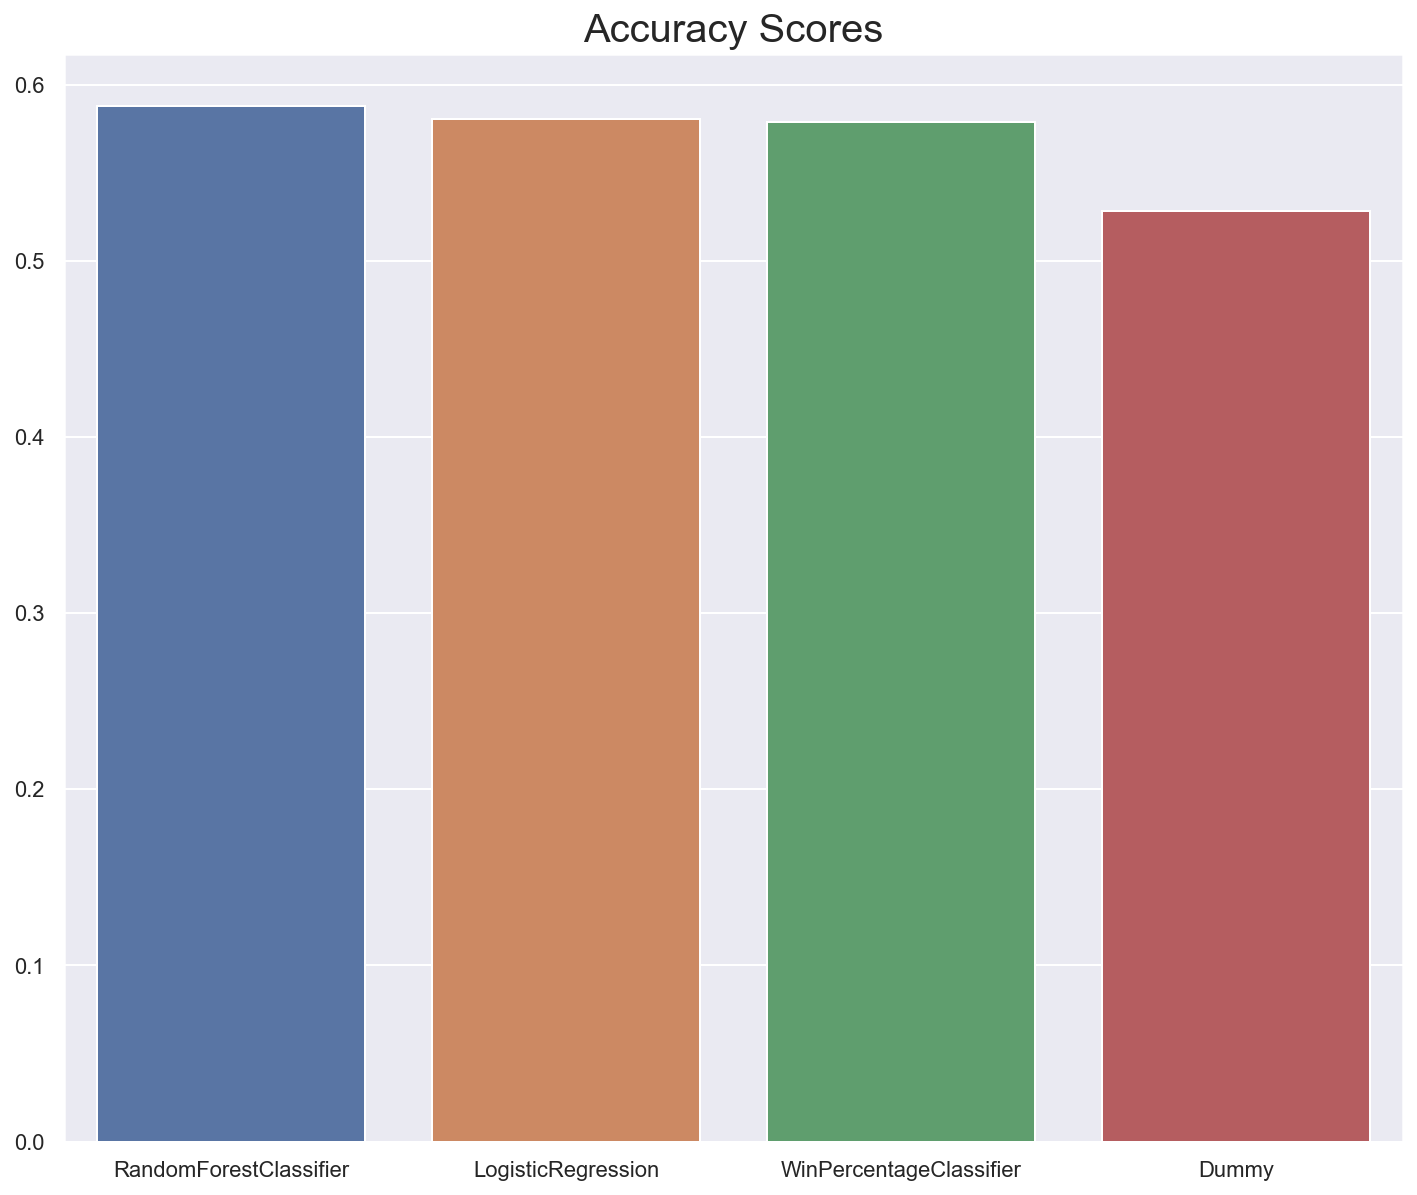

In [27]:
sns.barplot([x['model'] for x in accuracy_scores],[x['mean_accuracy']for x in accuracy_scores])
plt.title('Accuracy Scores',fontdict={'fontsize':20})
plt.savefig(image_dir+'acc.jpg')
plt.show()

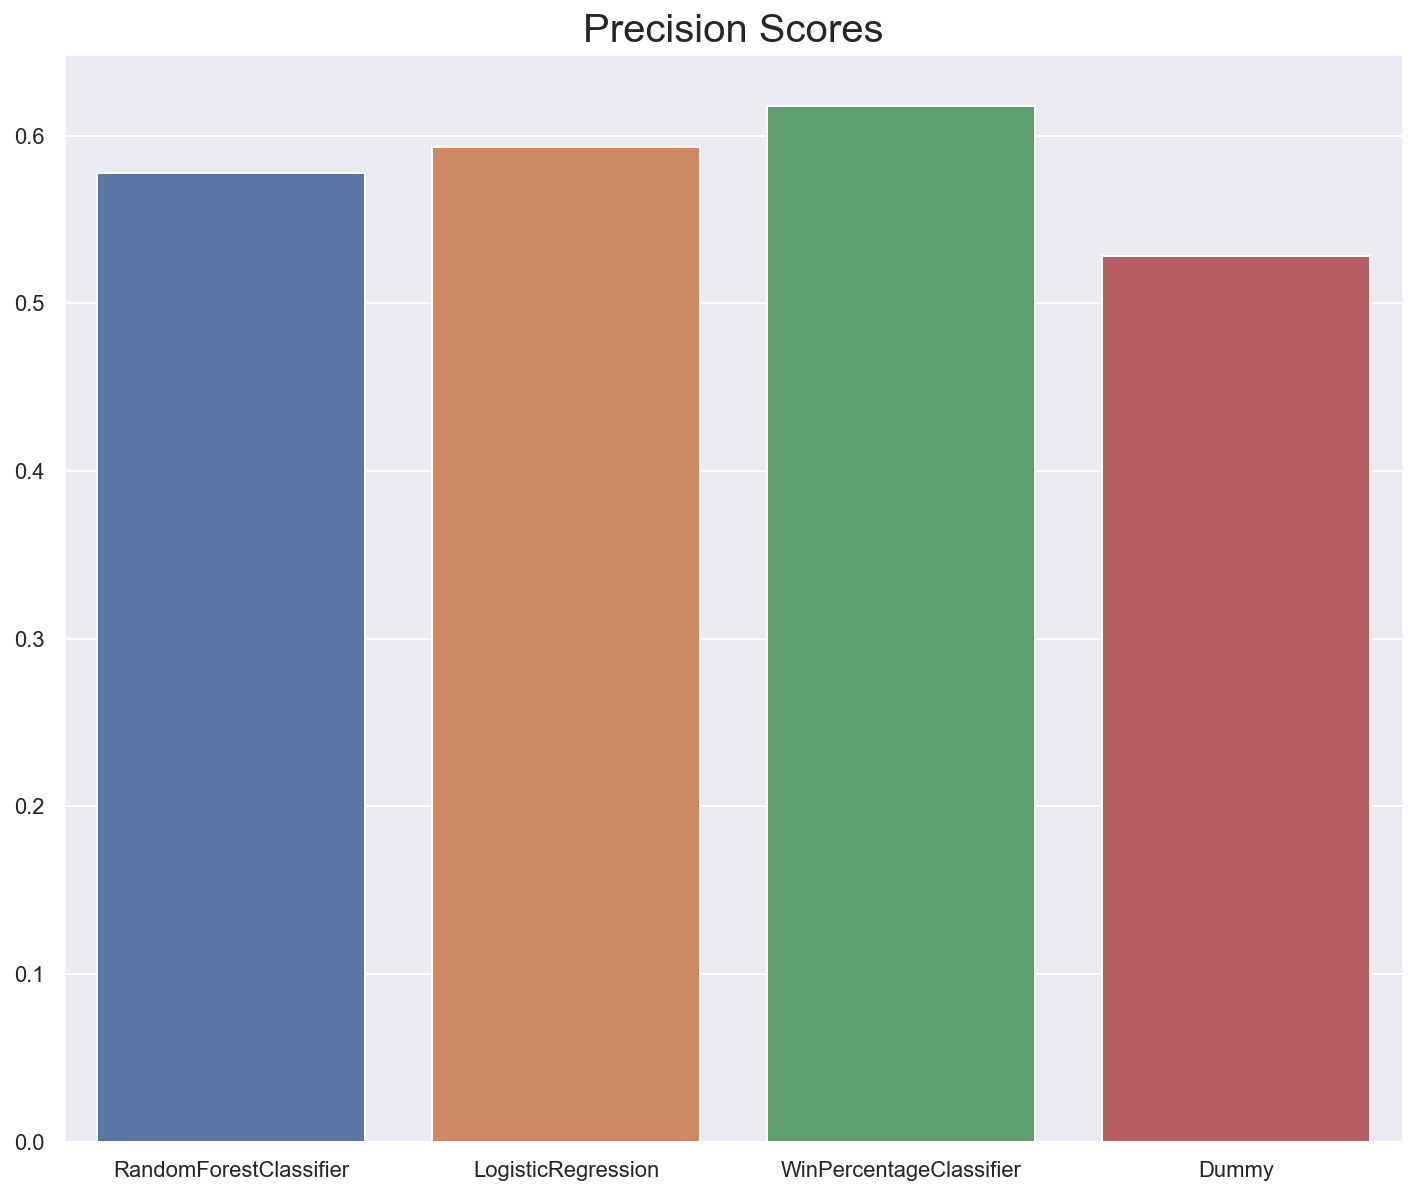

In [28]:
sns.barplot([x['model'] for x in precision_scores],[x['mean_precision']for x in precision_scores])
plt.title('Precision Scores',fontdict={'fontsize':20})
plt.savefig(image_dir+'PC.jpg')
plt.show()

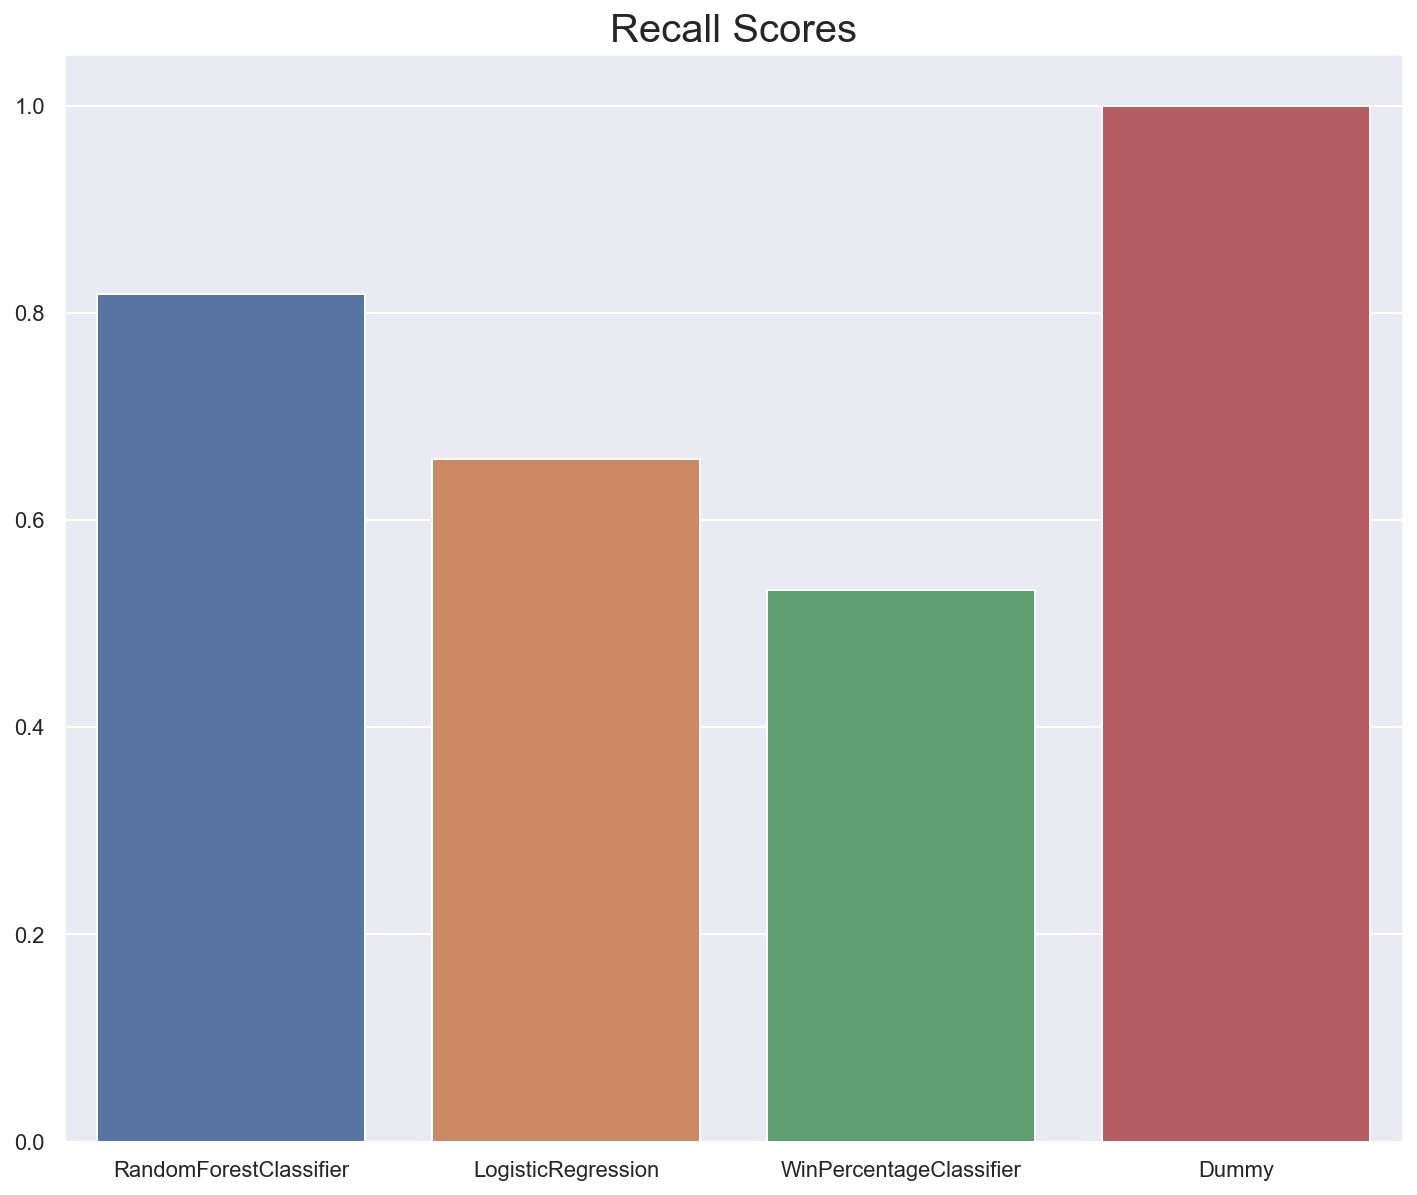

In [29]:
sns.barplot([x['model'] for x in recall_scores],[x['mean_recall']for x in recall_scores])
plt.title('Recall Scores',fontdict={'fontsize':20})
plt.savefig(image_dir+'recall.jpg')
plt.show()

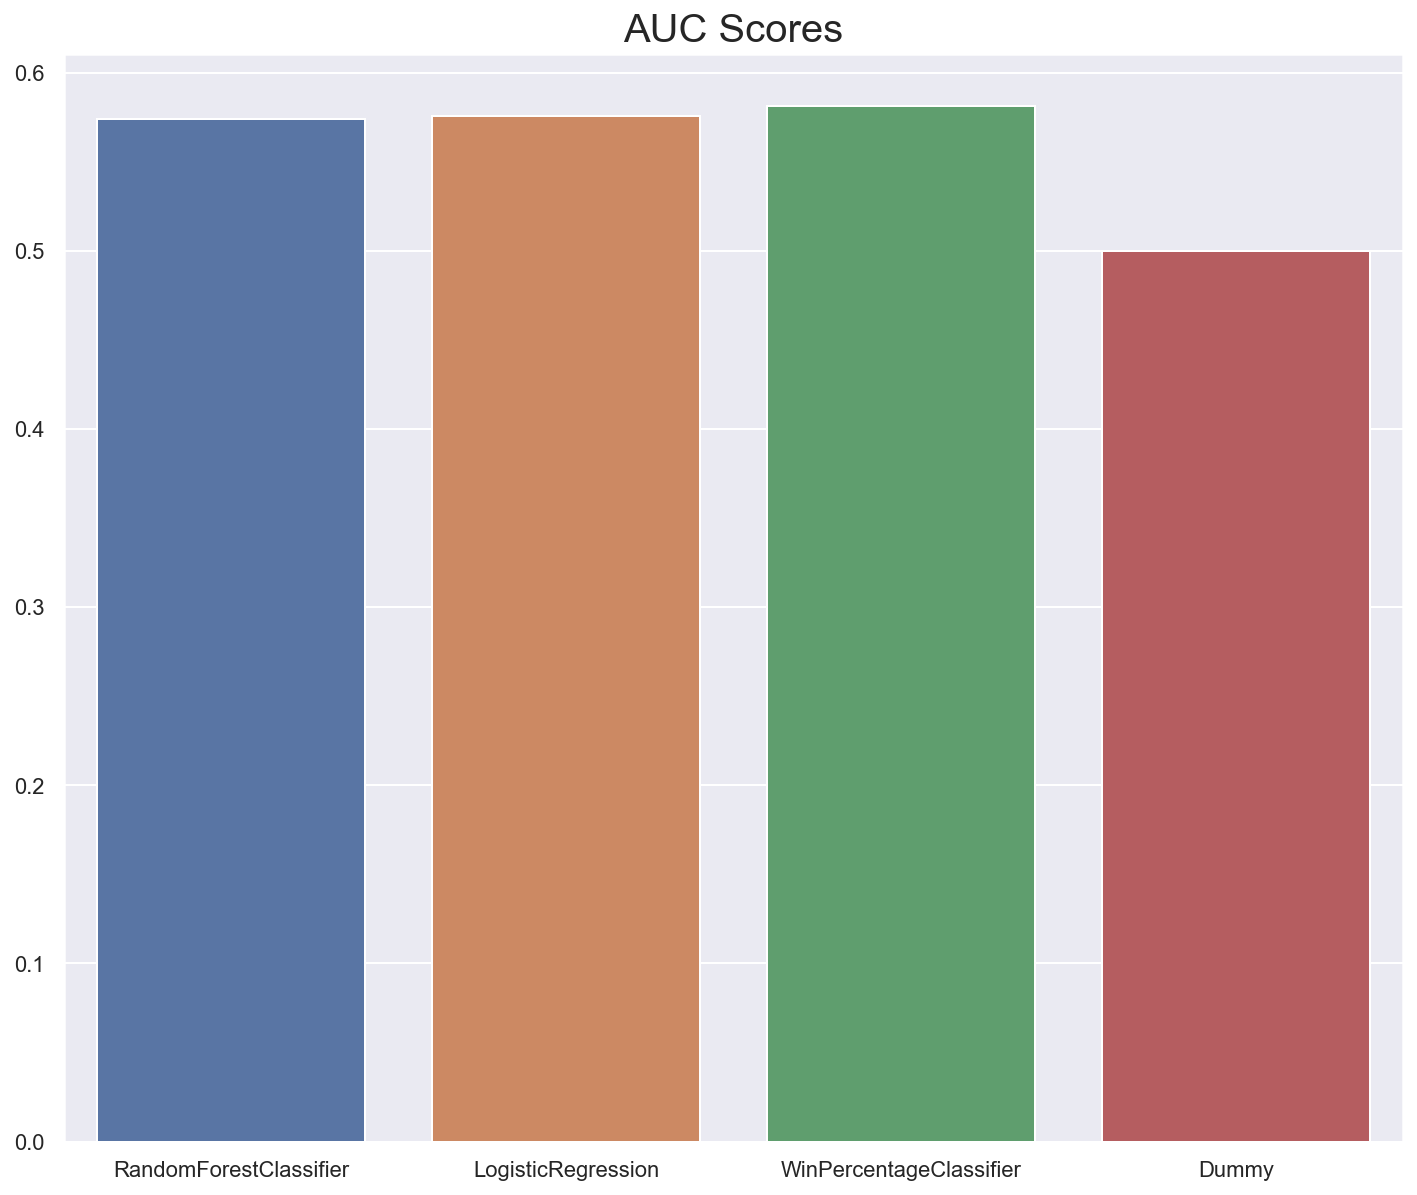

In [30]:
sns.barplot([x['model'] for x in auc_scores],[x['mean_auc']for x in auc_scores])
plt.title('AUC Scores',fontdict={'fontsize':20})
plt.savefig(image_dir+'auc.jpg')
plt.show()

## Confusion Matrix

RandomForestClassifier


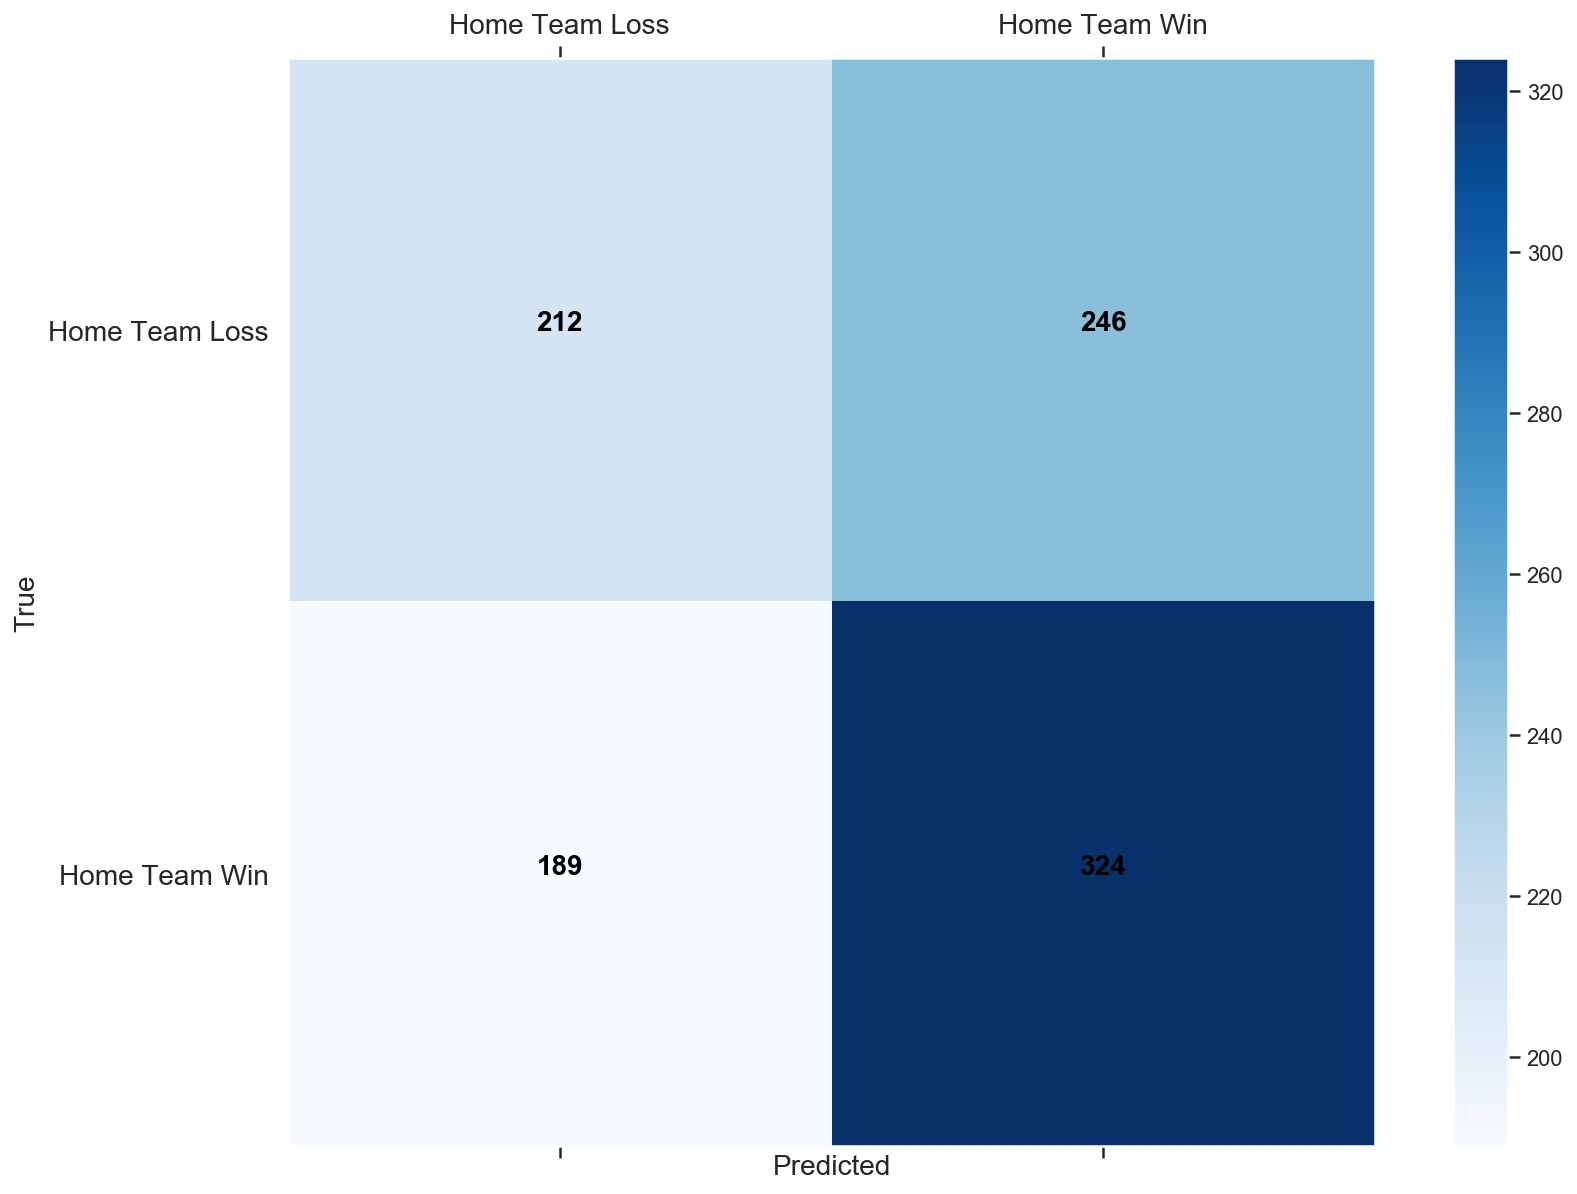

RandomForestClassifier


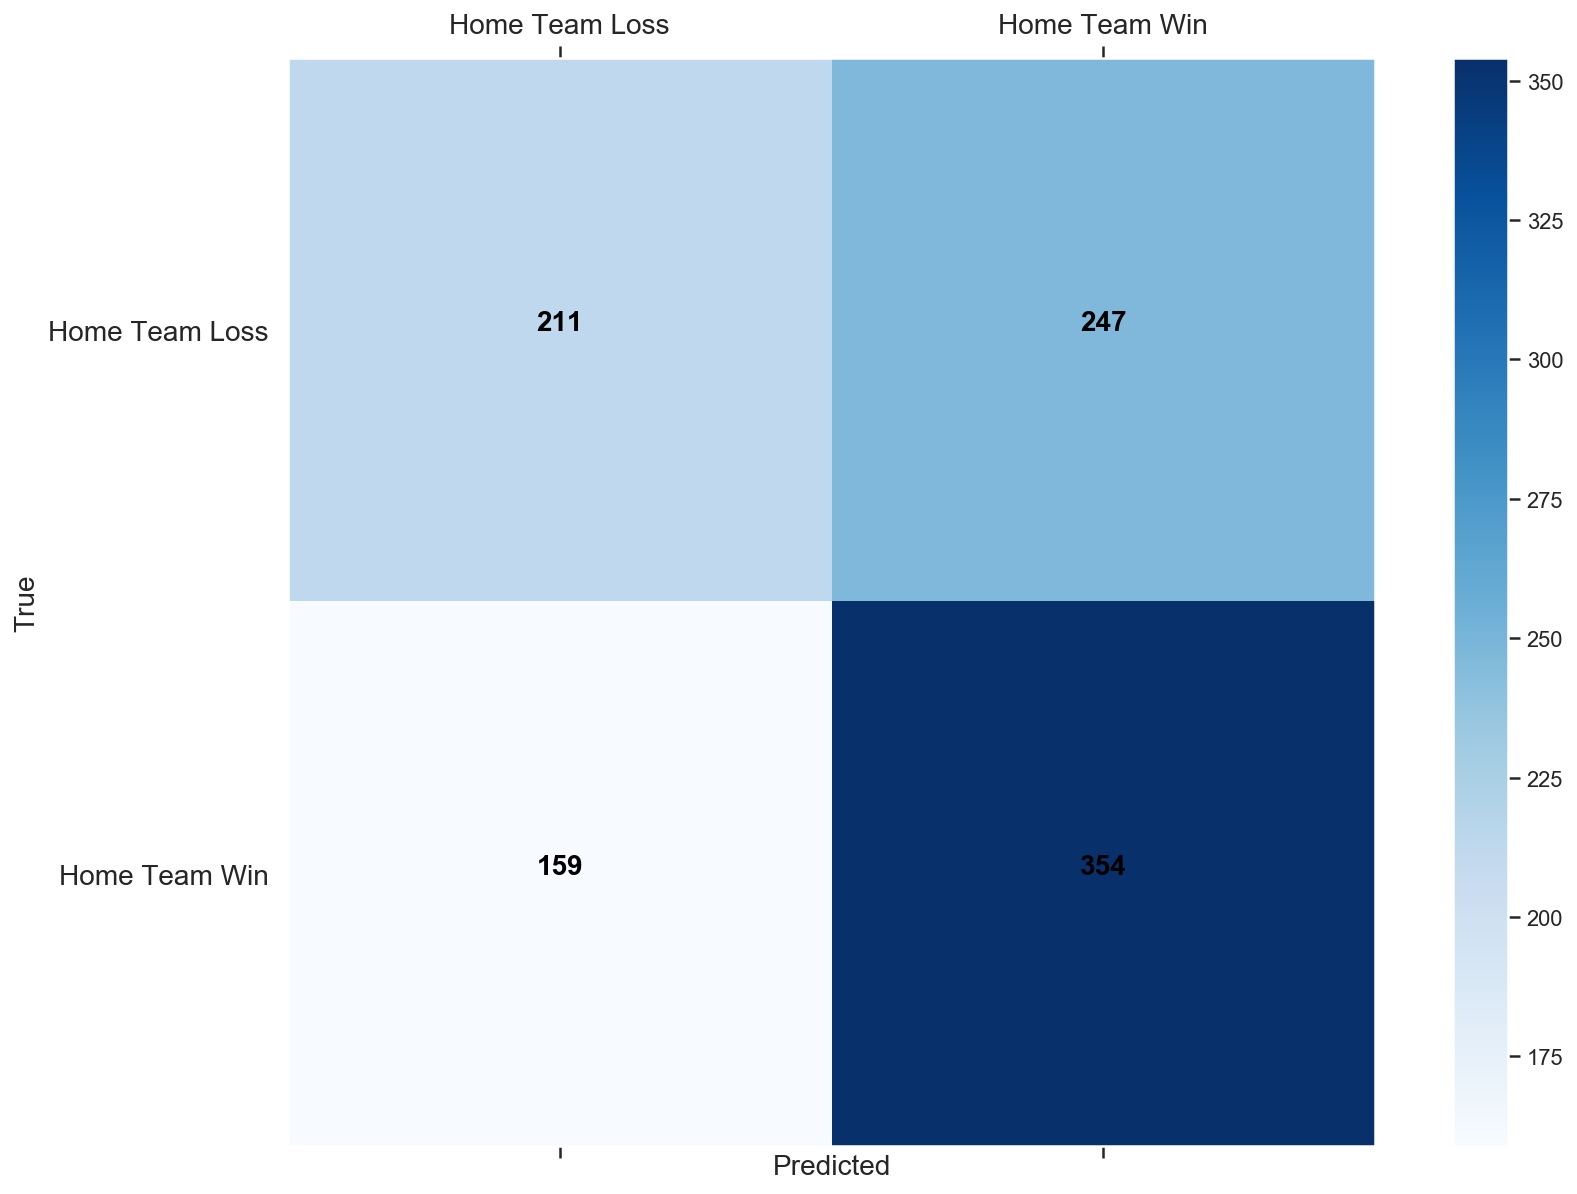

LogisticRegression


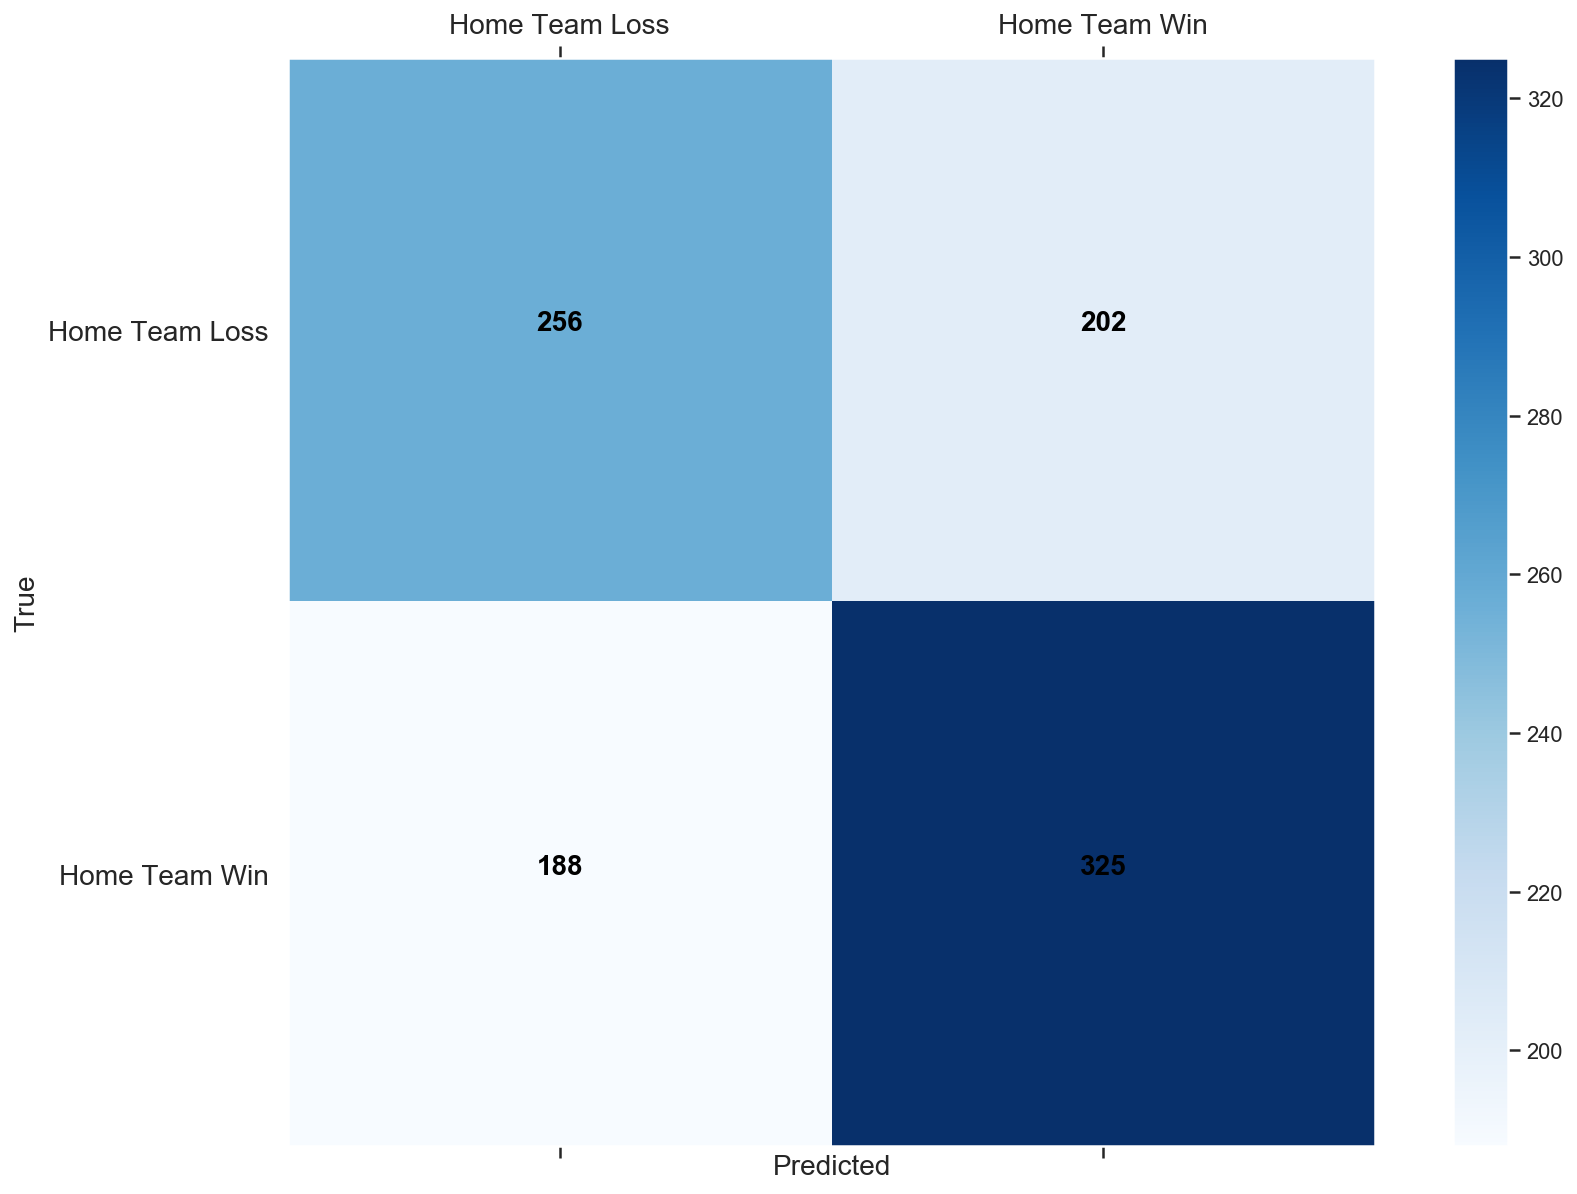

LogisticRegression


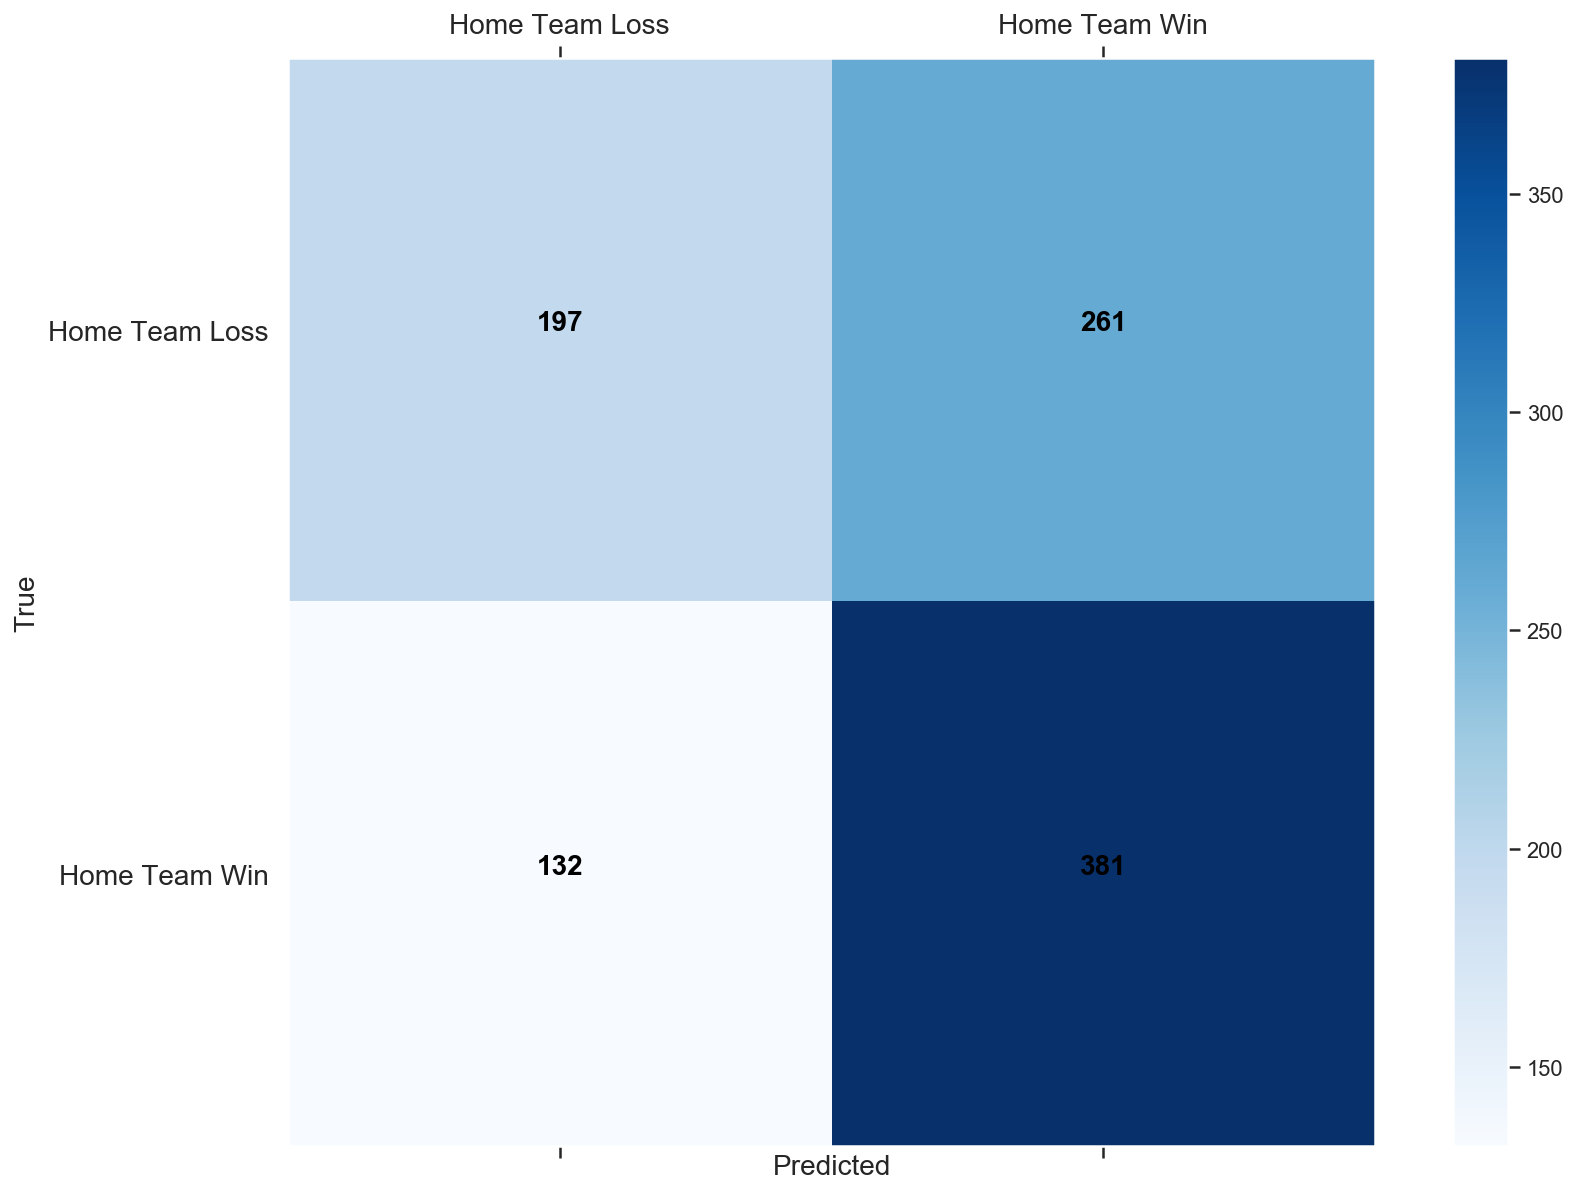

Win Percentage Classifier


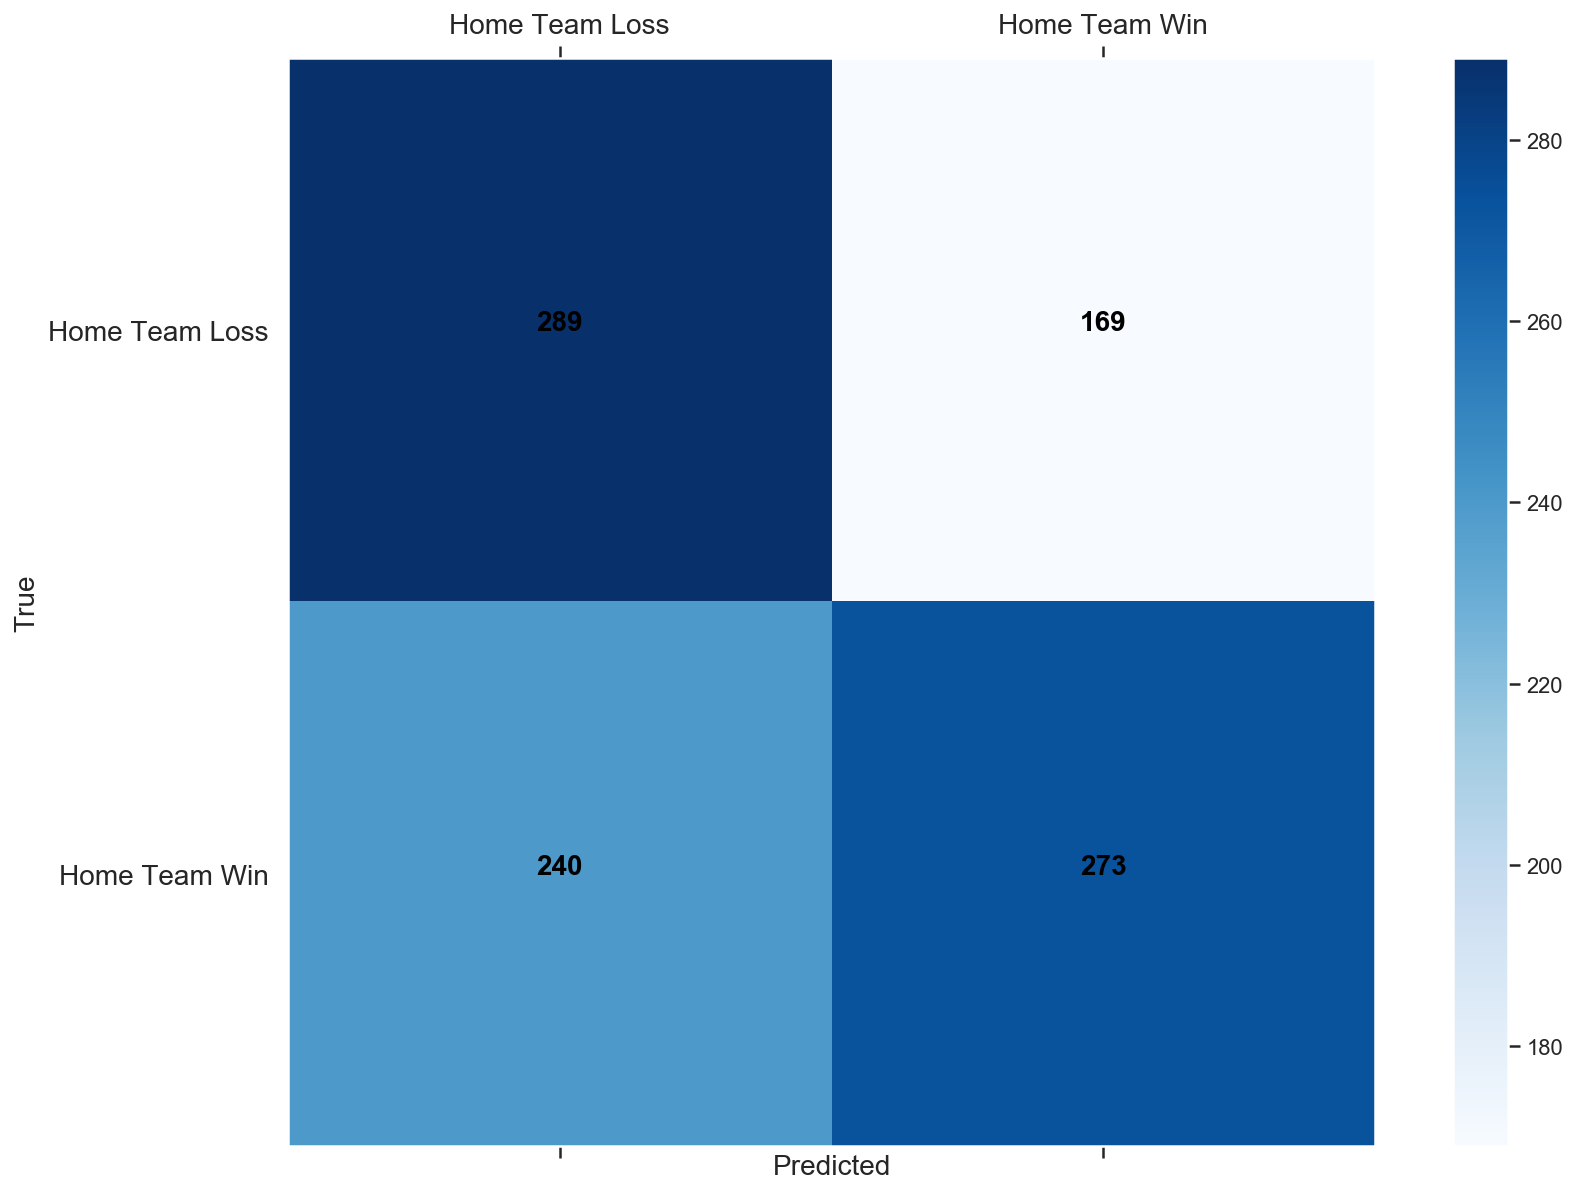

Win Percentage Classifier


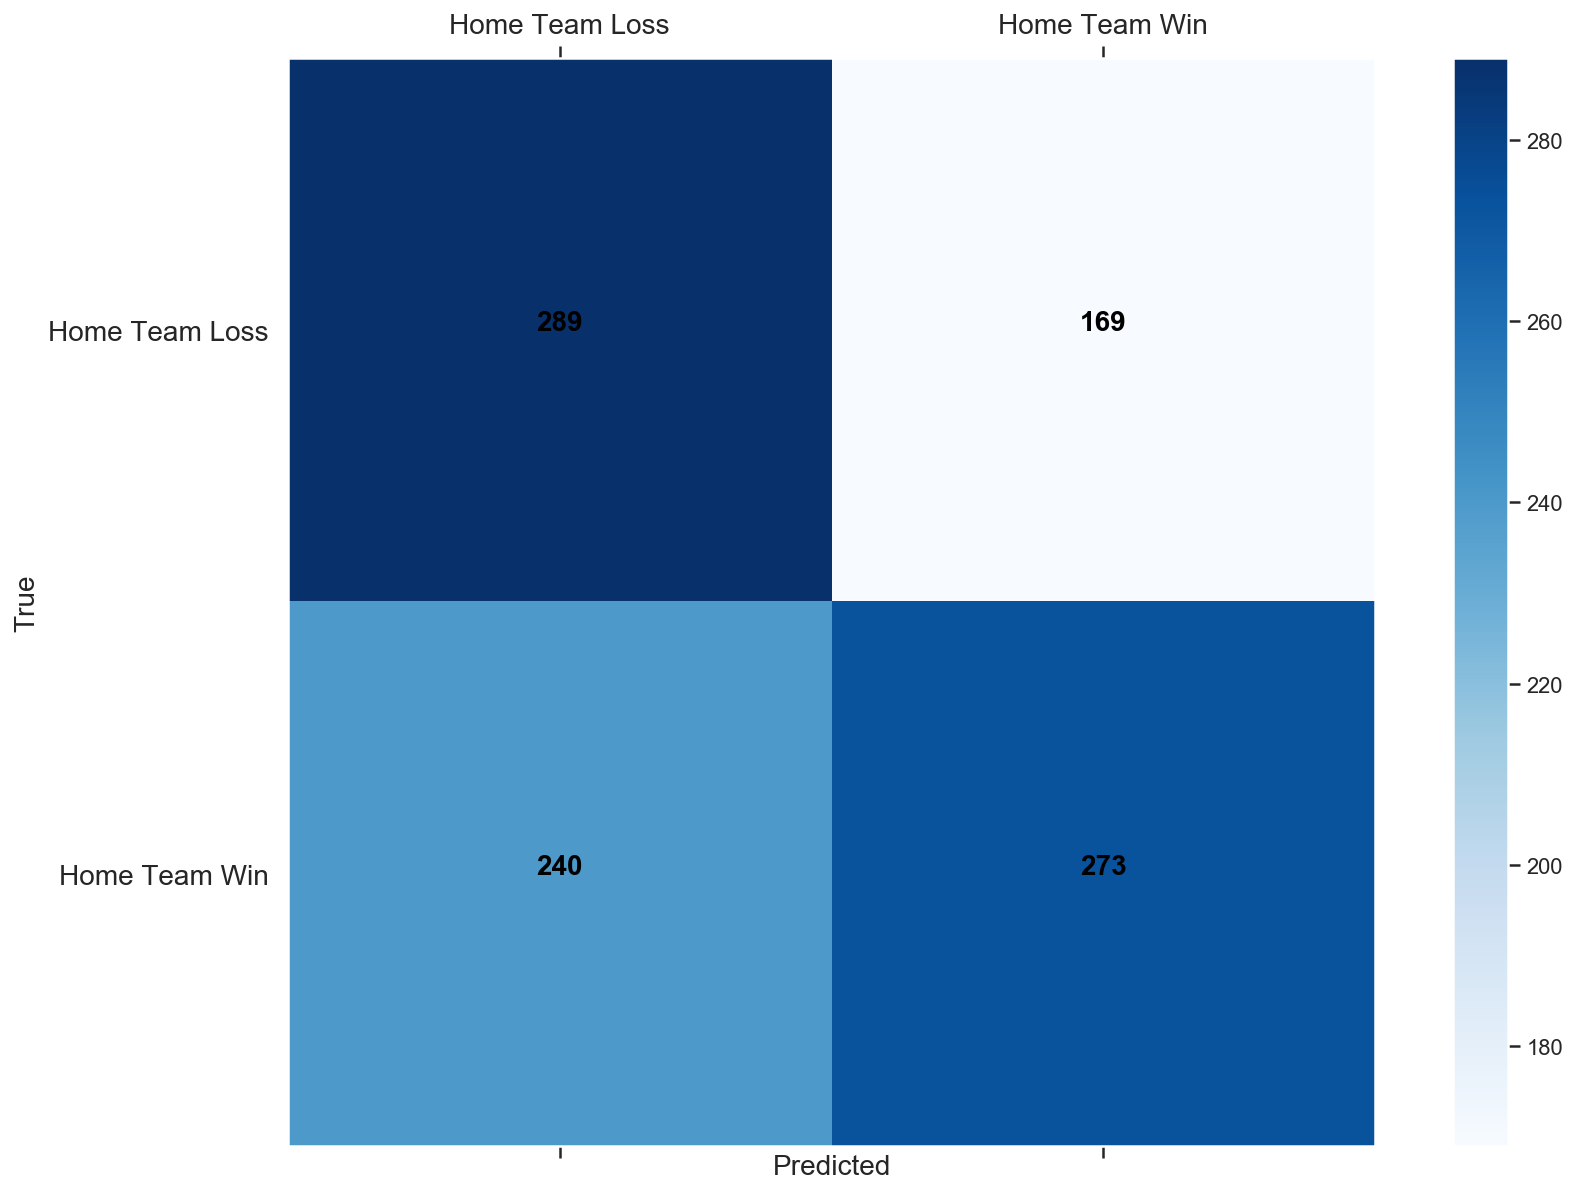

In [31]:
kfold = KFold(n_splits=2)
for model in models:
    for train, split in kfold.split(X,y):
        model.fit(X.iloc[train],y[train])
        y_pred=model.predict(X.iloc[test])
        try:
            model_name=model['classifier'].__repr__().split('(')[0]
            #plt.title(model_name)
            print(model_name)
            plot_confusion_matrix(y[test],y_pred)
        except:
            model_name='Win Percentage Classifier'
            print(model_name)
            plot_confusion_matrix(y[test],y_pred)


In [32]:
rf_65.fit(X,y)

Pipeline(memory=None,
         steps=[('attr_adder',
                 CombinedAttributesAdder(add_hitters_slashInteraction=True)),
                ('nan_imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('zero_imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=0, strategy='mean', verbose=0)),
                ('int...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=30, max_features=70,
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None

### Plot ROC curve, and predict_proba // threshold value, investigate bagging

In [33]:
from sklearn.metrics import roc_curve,precision_recall_curve

In [34]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [35]:
def plot_roc_curves(model,splits=2):
    rocs = []
    kfold=KFold(n_splits=splits)
    for train,test in kfold.split(X,y):
        model.fit(X.iloc[train],y[train])
        # Actual class predictions
        predictions = model.predict(X.iloc[test])
        # Probabilities for each class
        probs = model.predict_proba(X.iloc[test])

        roc=roc_auc_score(y[test],probs[:,1])
        rocs.append(roc)

        fpr,tpr,thresholds = roc_curve(y[test],probs[:,1])

        plot_roc_curve(fpr,tpr)
        plt.show()
    print(np.mean(rocs))

In [36]:
dummy = WinPercentageClassifier()

In [37]:
from sklearn.model_selection import KFold

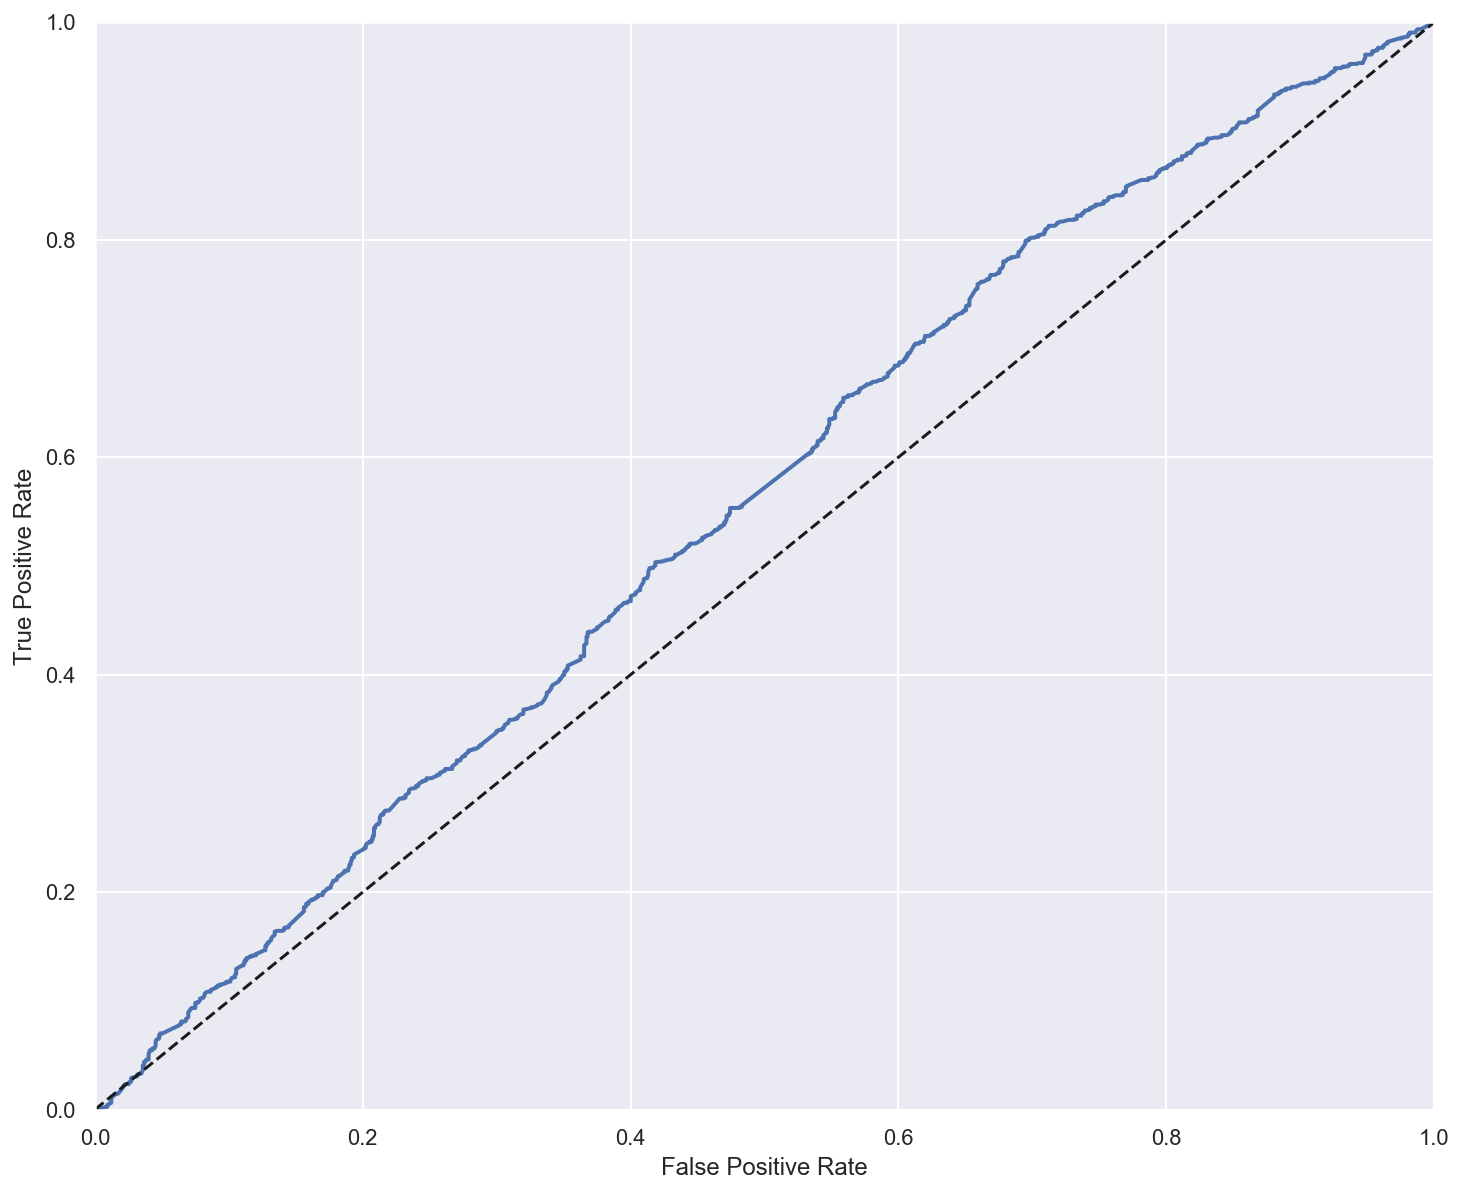

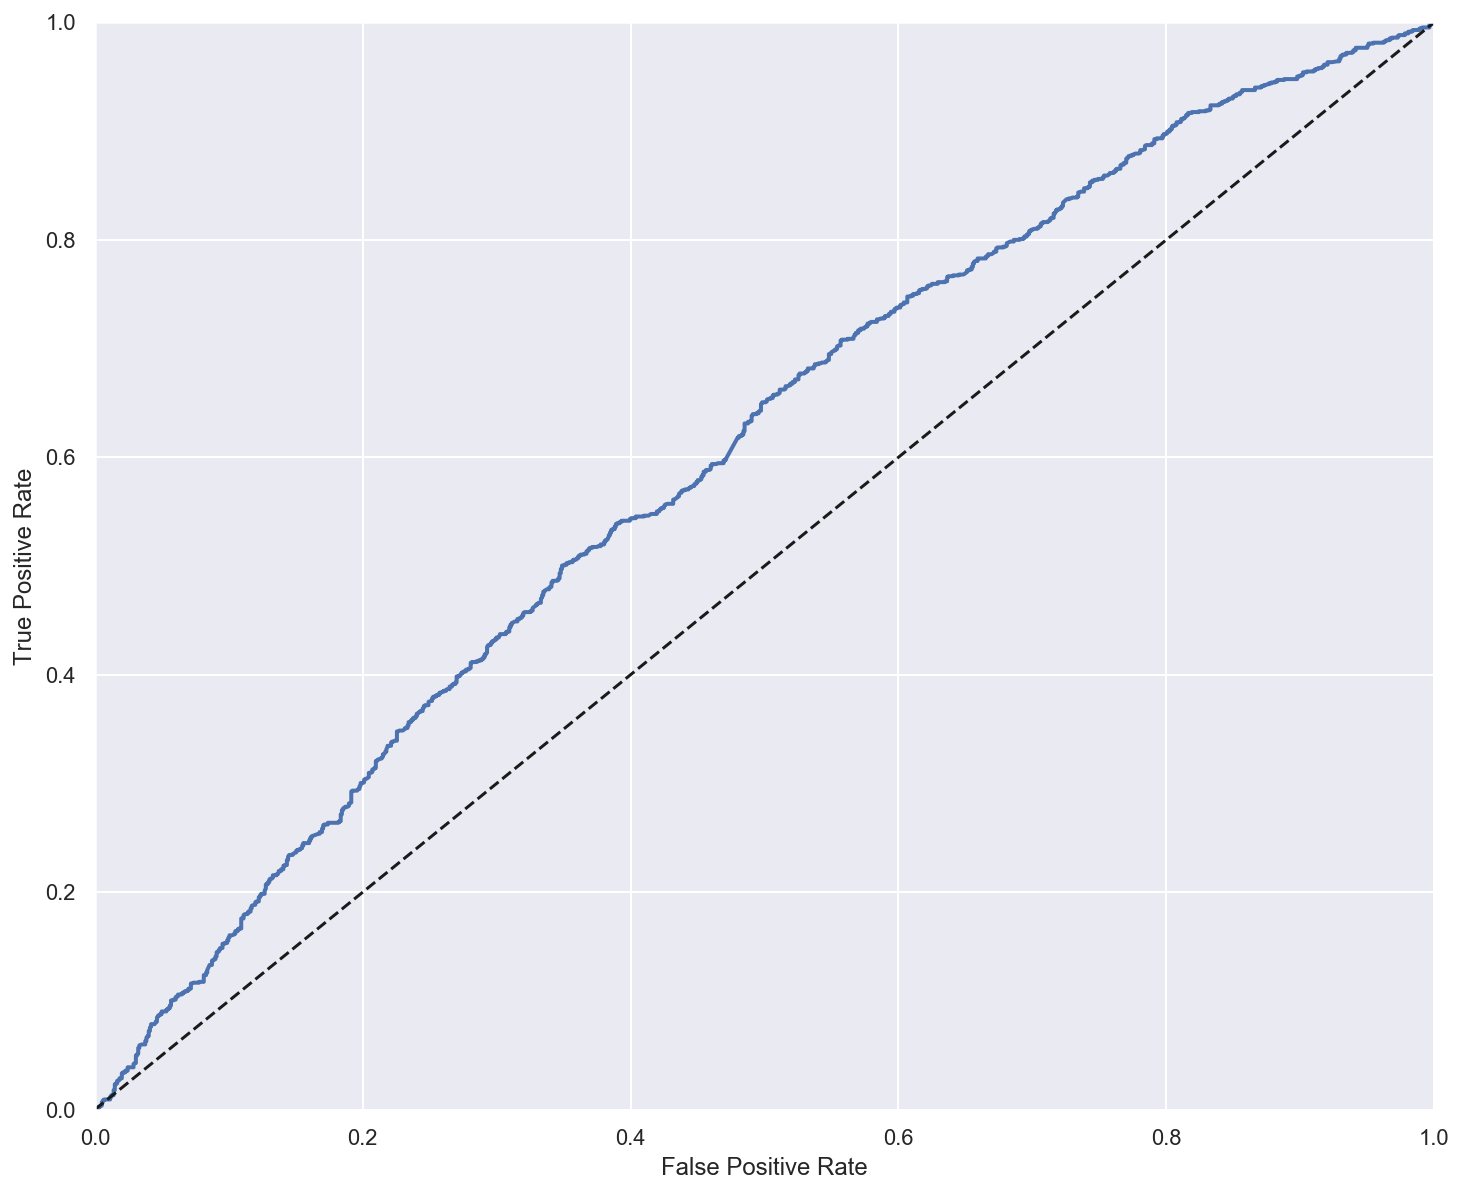

0.576908479161578


In [38]:
plot_roc_curves(dummy)

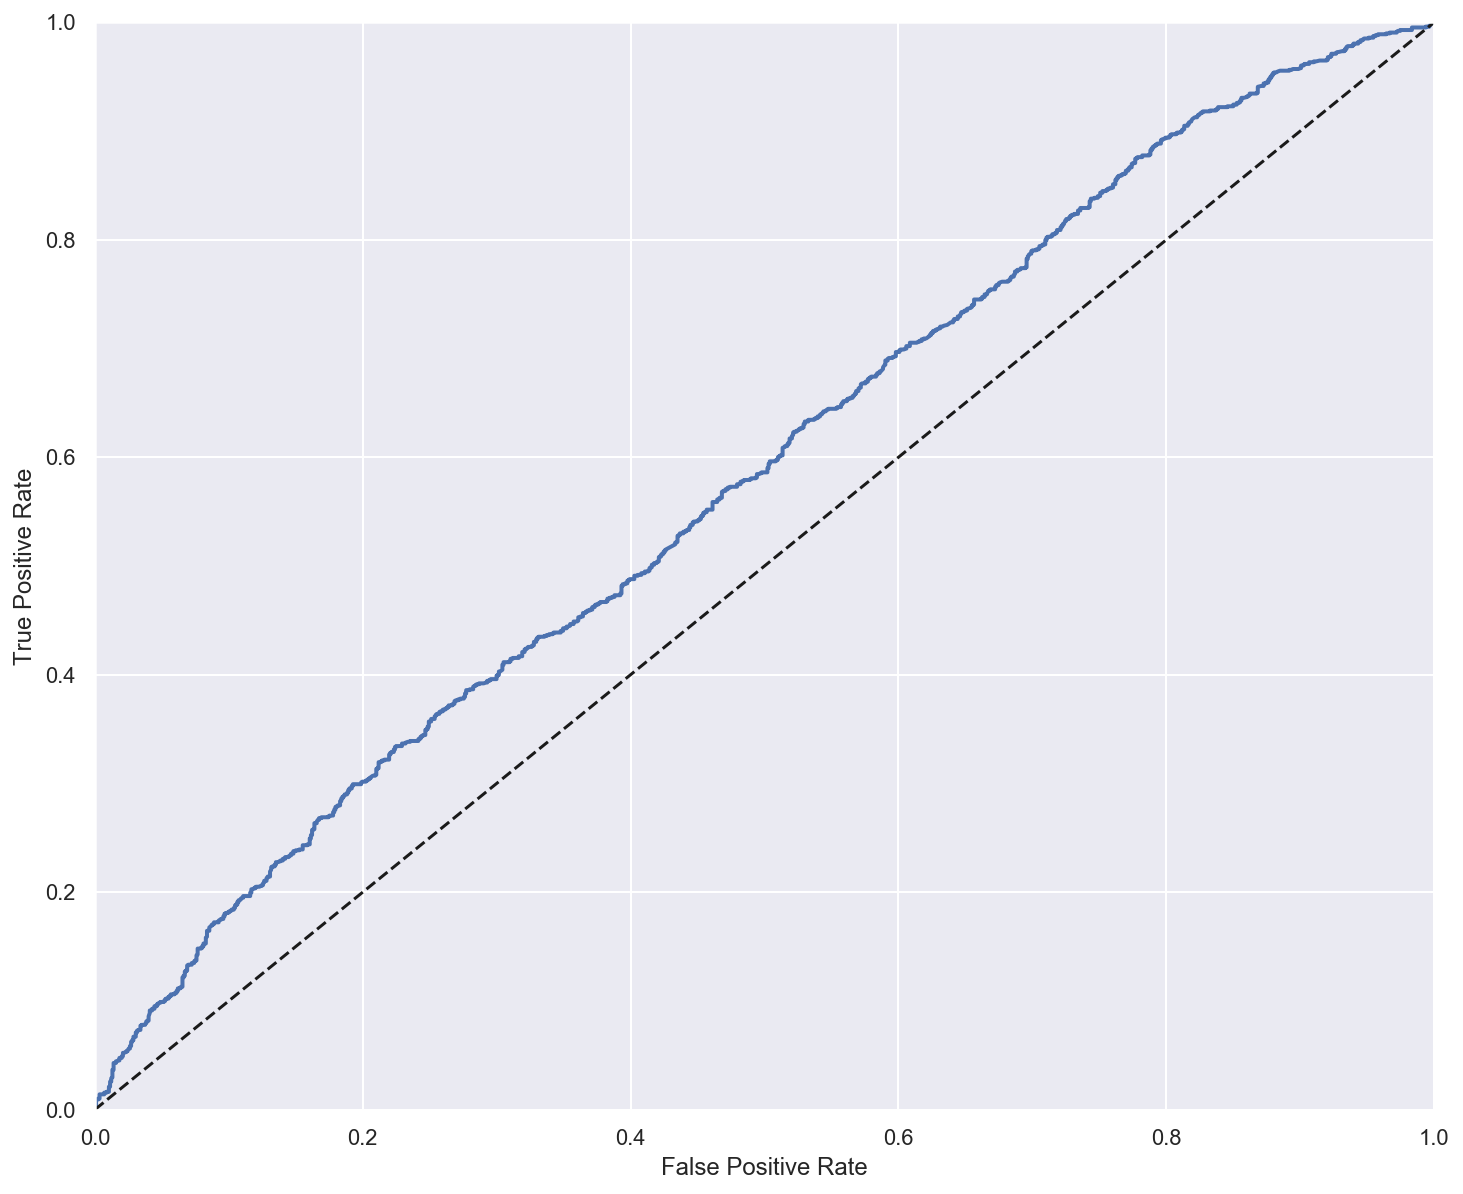

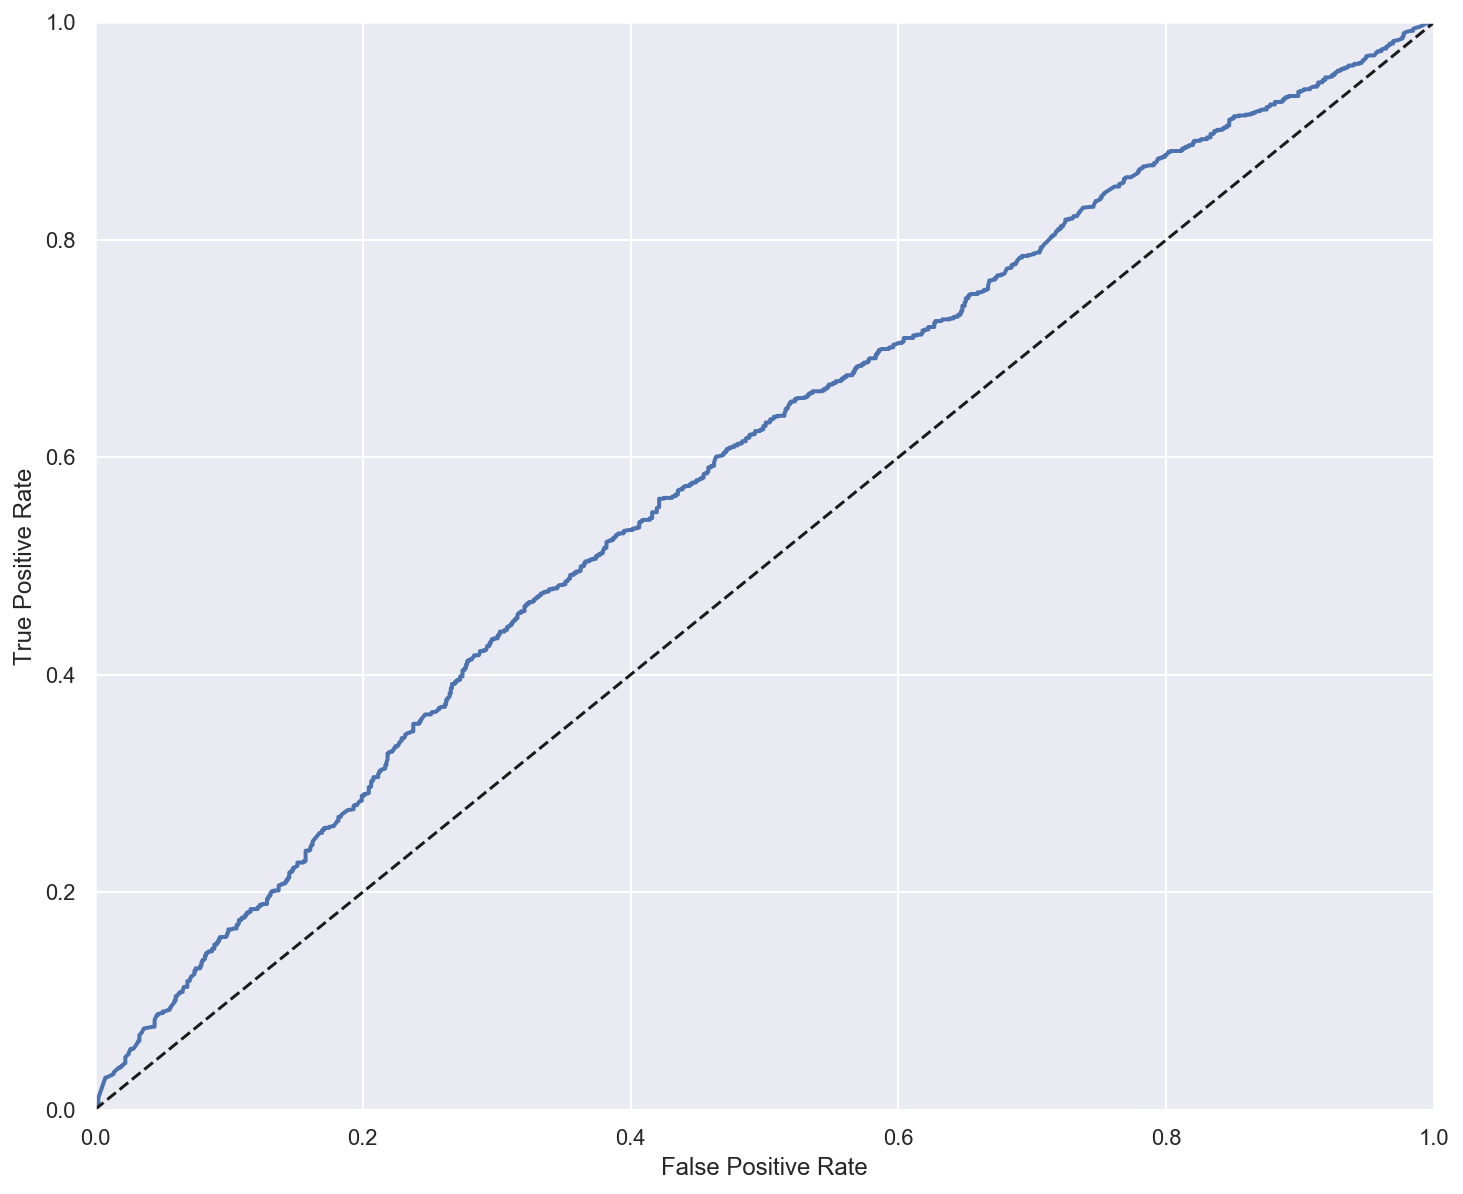

0.5840319397733525


In [39]:
plot_roc_curves(rf_65)

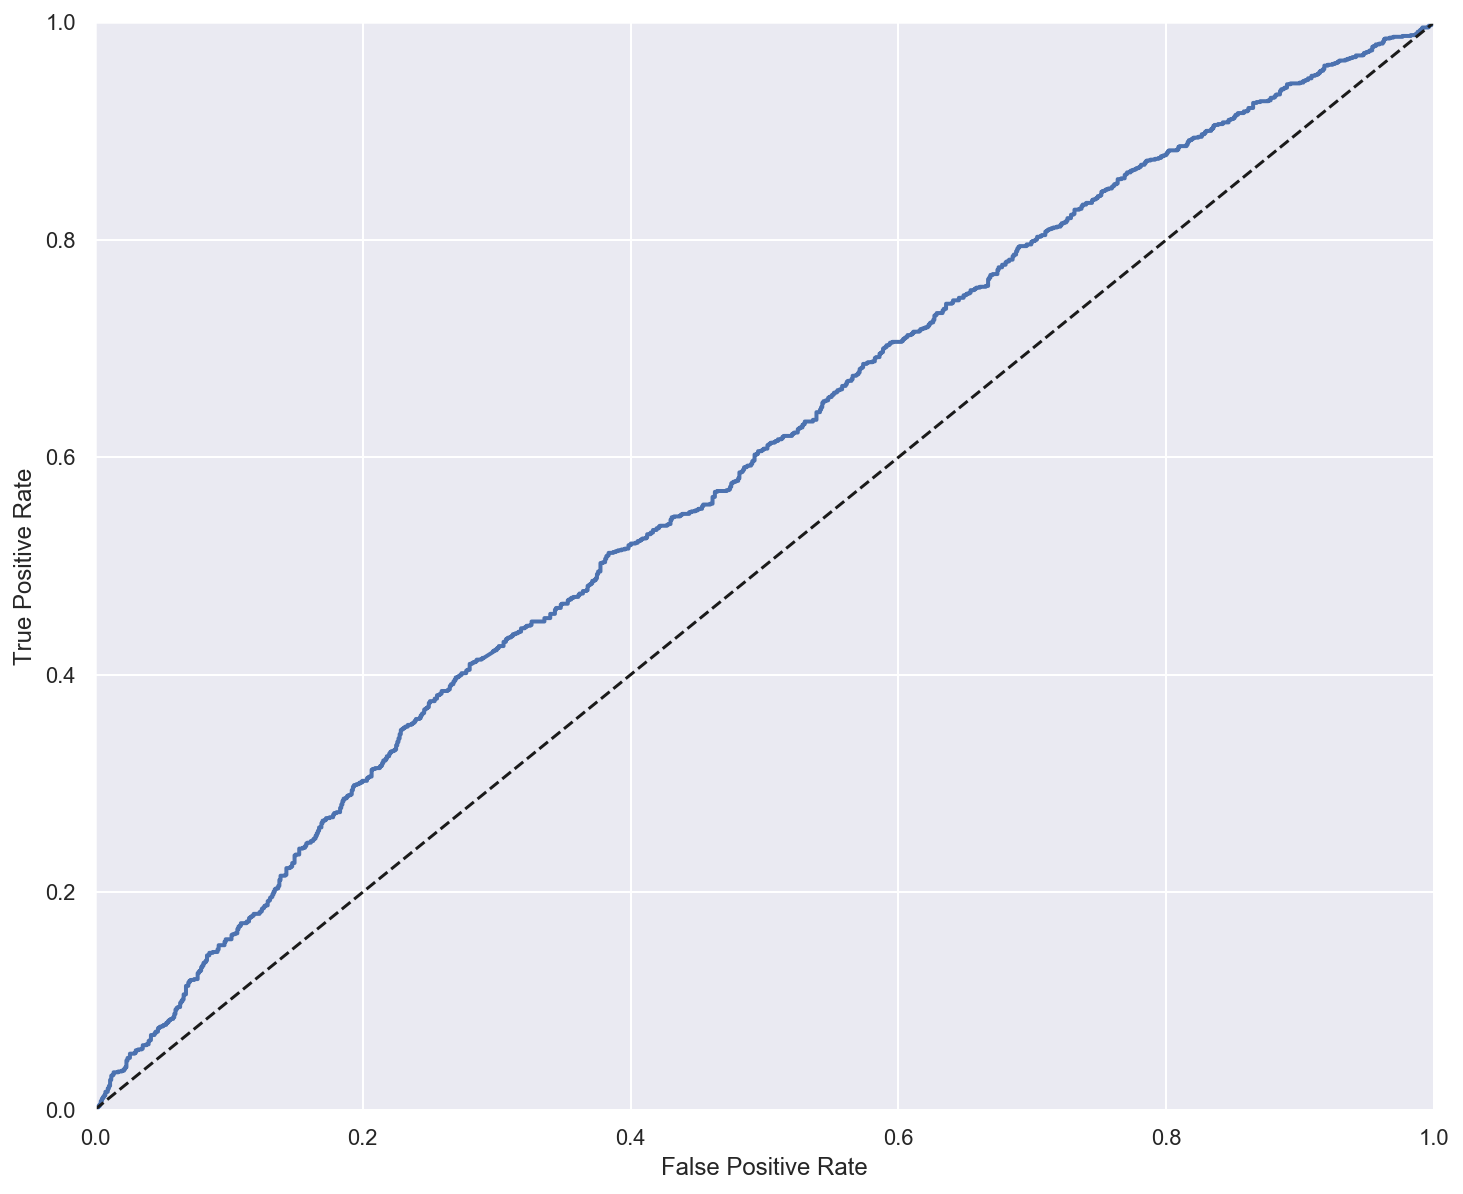

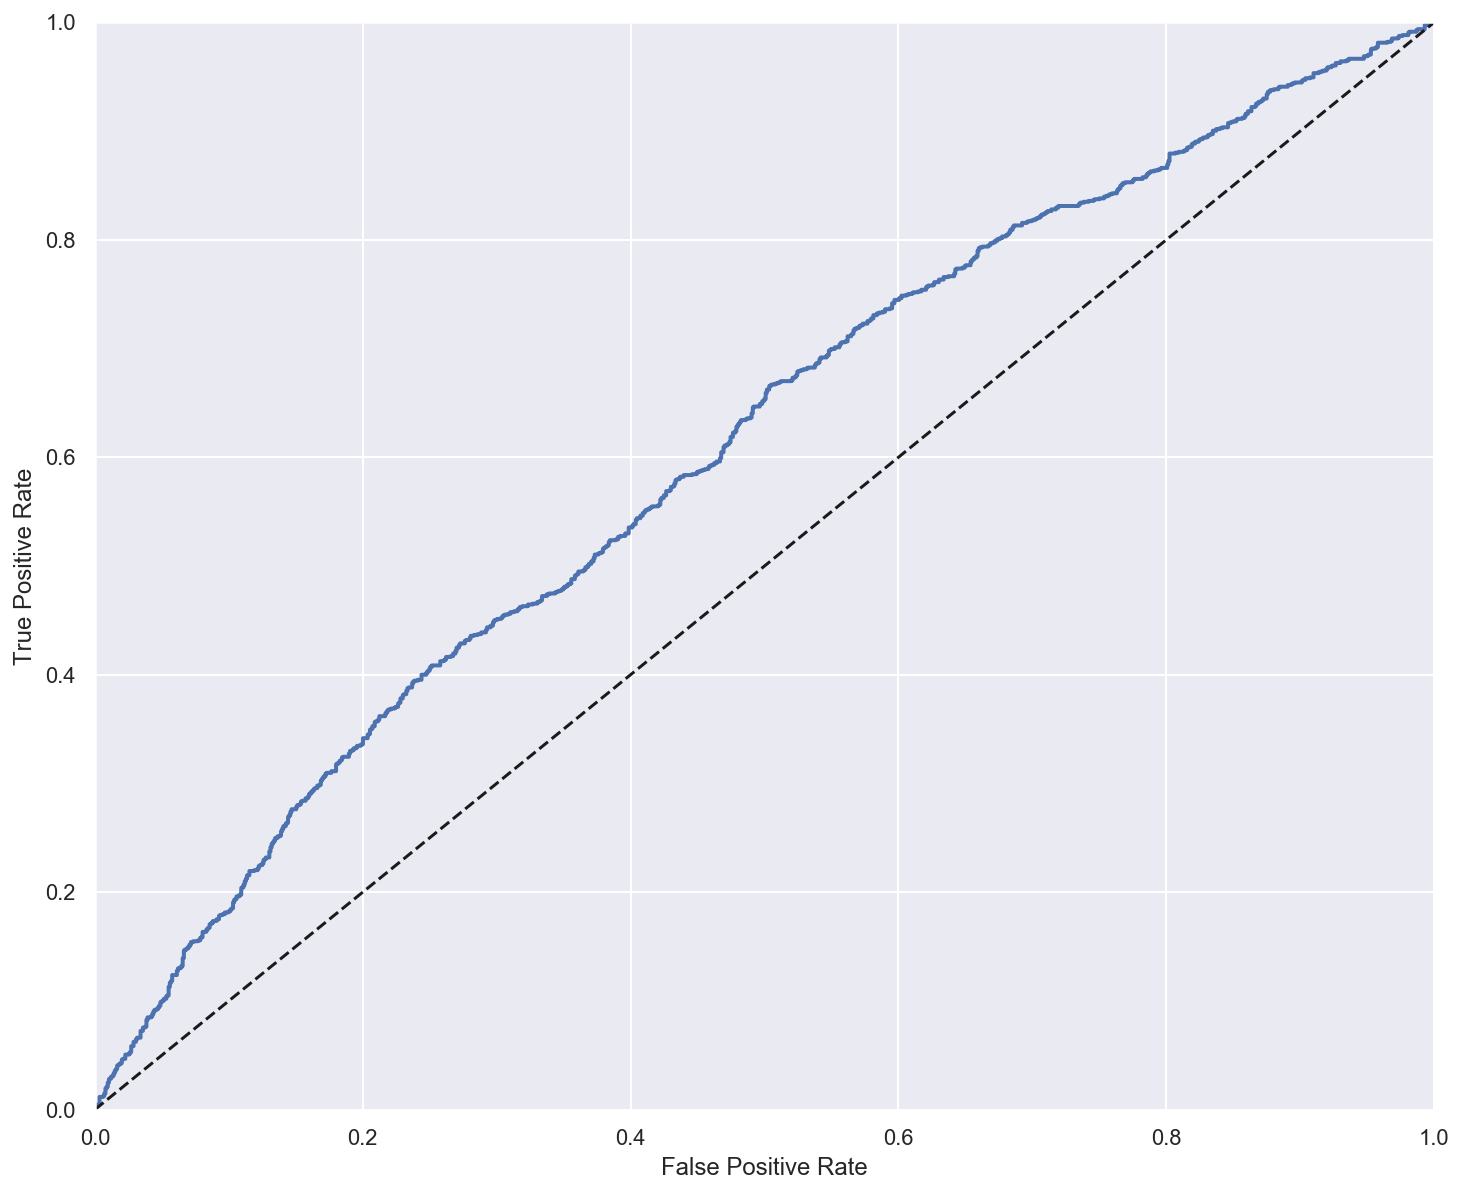

0.5944045851088944


In [40]:
plot_roc_curves(lr_clf,2)

In [41]:
def feature_importance(model,X,y,cv=False):  
    # Extract feature importances
    if cv:
        kfold = KFold(n_splits=cv)
        for train,test in kfold.split(X,y):
            X_transformed = model['attr_adder'].fit_transform(X,y)
            model.fit(X.iloc[train],y[train])
            pred = model.predict(X.iloc[test])
    #         for name, importance in zip(X.columns, model['classifier'].feature_importances_):
    #             print(name, "=", importance)

            try:
                fi = [(name,importance) for name,importance 
                  in zip(X.columns, model['classifier'].feature_importances_) if importance >0]
            except:
                fi = [(name,importance) for name,importance 
                  in zip(X.columns, model['classifier'].coef_[0,:])]

            fi.sort(key=lambda x:x[1])
            return fi
    else:
  
        model.fit(X,y)
        pred = model.predict(X)
#         for name, importance in zip(X.columns, model['classifier'].feature_importances_):
#             print(name, "=", importance)

        try:
            fi = [(name,importance) for name,importance 
              in zip(X.columns, model['classifier'].feature_importances_) if importance >0]
        except:
            fi = [(name,importance) for name,importance 
              in zip(X.columns, model['classifier'].coef_[0,:])]

        fi.sort(key=lambda x:x[1])
        return fi






In [42]:
rf_feature_importance=feature_importance(rf_65,X,y)

In [46]:
lr_l1_feature_importance=feature_importance(lr_l1,X,y)
lr_clf_feature_importance=feature_importance(lr_clf,X,y)

In [44]:
lr_l1_feature_importance

[('home_relief_PO_O_mean', -1.6062222762400193),
 ('homeHitter_slashInteraction', -1.5193027253785465),
 ('away_hitters_FO_O_std', -0.9344037731295273),
 ('home_starter_LO_O', -0.9094008688987927),
 ('away_relief_OBP_mean', -0.9057034879639446),
 ('away_starter_BA', -0.8931307661983854),
 ('home_hitters_PO_O_mean', -0.7749143342003587),
 ('home_hitters_GO_O_std', -0.44307453879465536),
 ('home_starter_PO_O', -0.3780122814949272),
 ('away_hitters_GO_O_mean', -0.3598235809256033),
 ('home_relief_SLG_mean', -0.12958614662037263),
 ('home_relief_WHIP_mean', -0.12585078432821456),
 ('away_relief_SOW_std', -0.10454964584640608),
 ('home_relief_SOW_std', -0.08155705470276743),
 ('home_relief_HR9_std', -0.07896660193303881),
 ('away_starter_SOW', -0.04865779238042404),
 ('home_relief_HR9_mean', -0.04681909174399426),
 ('home_starter_SO9', -0.04194120167241938),
 ('away_relief_H9_std', -0.032204434361661934),
 ('home_relief_SO9_std', -0.03177480840193116),
 ('away_relief_WHIP_std', -0.026678076

In [45]:
rf_feature_importance

[('home_starter_GO_O', 0.008695652173913044),
 ('away_relief_OBP_mean', 0.008695652173913044),
 ('home_relief_H9_std', 0.008695652173913044),
 ('home_relief_OBP_std', 0.017391304347826087),
 ('away_hitters_OBP_std', 0.017391304347826087),
 ('awayHitter_slashInteraction', 0.034782608695652174),
 ('home_relief_BA_std', 0.05217391304347826),
 ('home_hitters_OBP_std', 0.05217391304347826),
 ('away_hitters_OBP_mean', 0.06086956521739131),
 ('awayWin_pct', 0.21739130434782608),
 ('homeHitter_slashInteraction', 0.5217391304347826)]

In [47]:
lr_clf_feature_importance

[('home_relief_PO_O_mean', -1.9942946717456425),
 ('away_relief_OBP_mean', -1.6693724162842303),
 ('homeHitter_slashInteraction', -1.514453772189327),
 ('away_starter_BA', -1.4665026430138357),
 ('home_relief_SLG_mean', -1.3238114476156582),
 ('away_hitters_FO_O_std', -1.3194826228753418),
 ('home_hitters_PO_O_mean', -1.3194826228753418),
 ('home_starter_LO_O', -1.2121909501550334),
 ('away_relief_FO_O_mean', -1.0446119703083483),
 ('home_starter_PO_O', -0.8340496396853022),
 ('home_hitters_GO_O_std', -0.7419197943074255),
 ('away_hitters_GO_O_mean', -0.7419197943074255),
 ('away_relief_GO_O_mean', -0.7260213197004256),
 ('away_starter_SLG', -0.6721080552881965),
 ('away_starter_FO_O', -0.6228752406768197),
 ('away_starter_PO_O', -0.5696831940744104),
 ('home_relief_BA_mean', -0.5395953696591427),
 ('home_relief_LO_O_mean', -0.5225584656851384),
 ('away_hitters_SLG_std', -0.5018060521274162),
 ('home_hitters_OBP_mean', -0.5018060521274162),
 ('home_relief_BA_std', -0.4853504593693829),

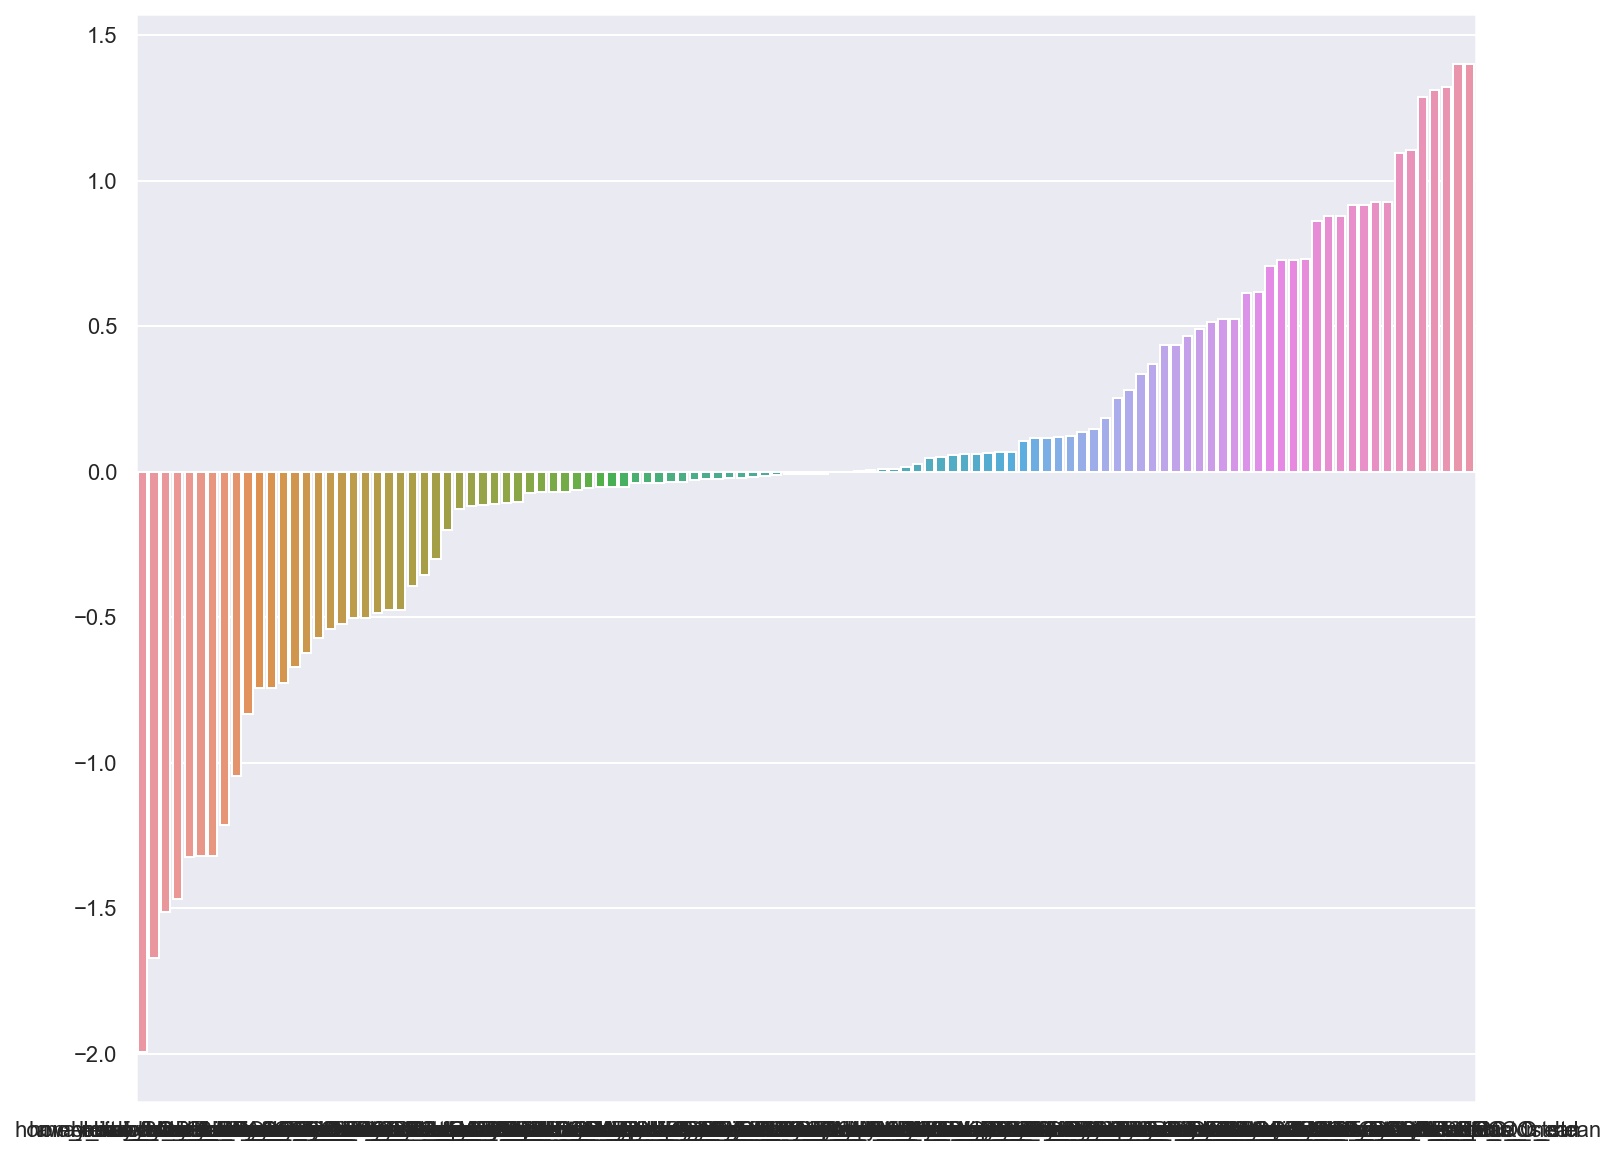

In [53]:
sns.barplot(x=[t[0] for t in lr_clf_feature_importance],y=[t[1] for t in lr_clf_feature_importance])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]),
 <a list of 83 Text xticklabel objects>)

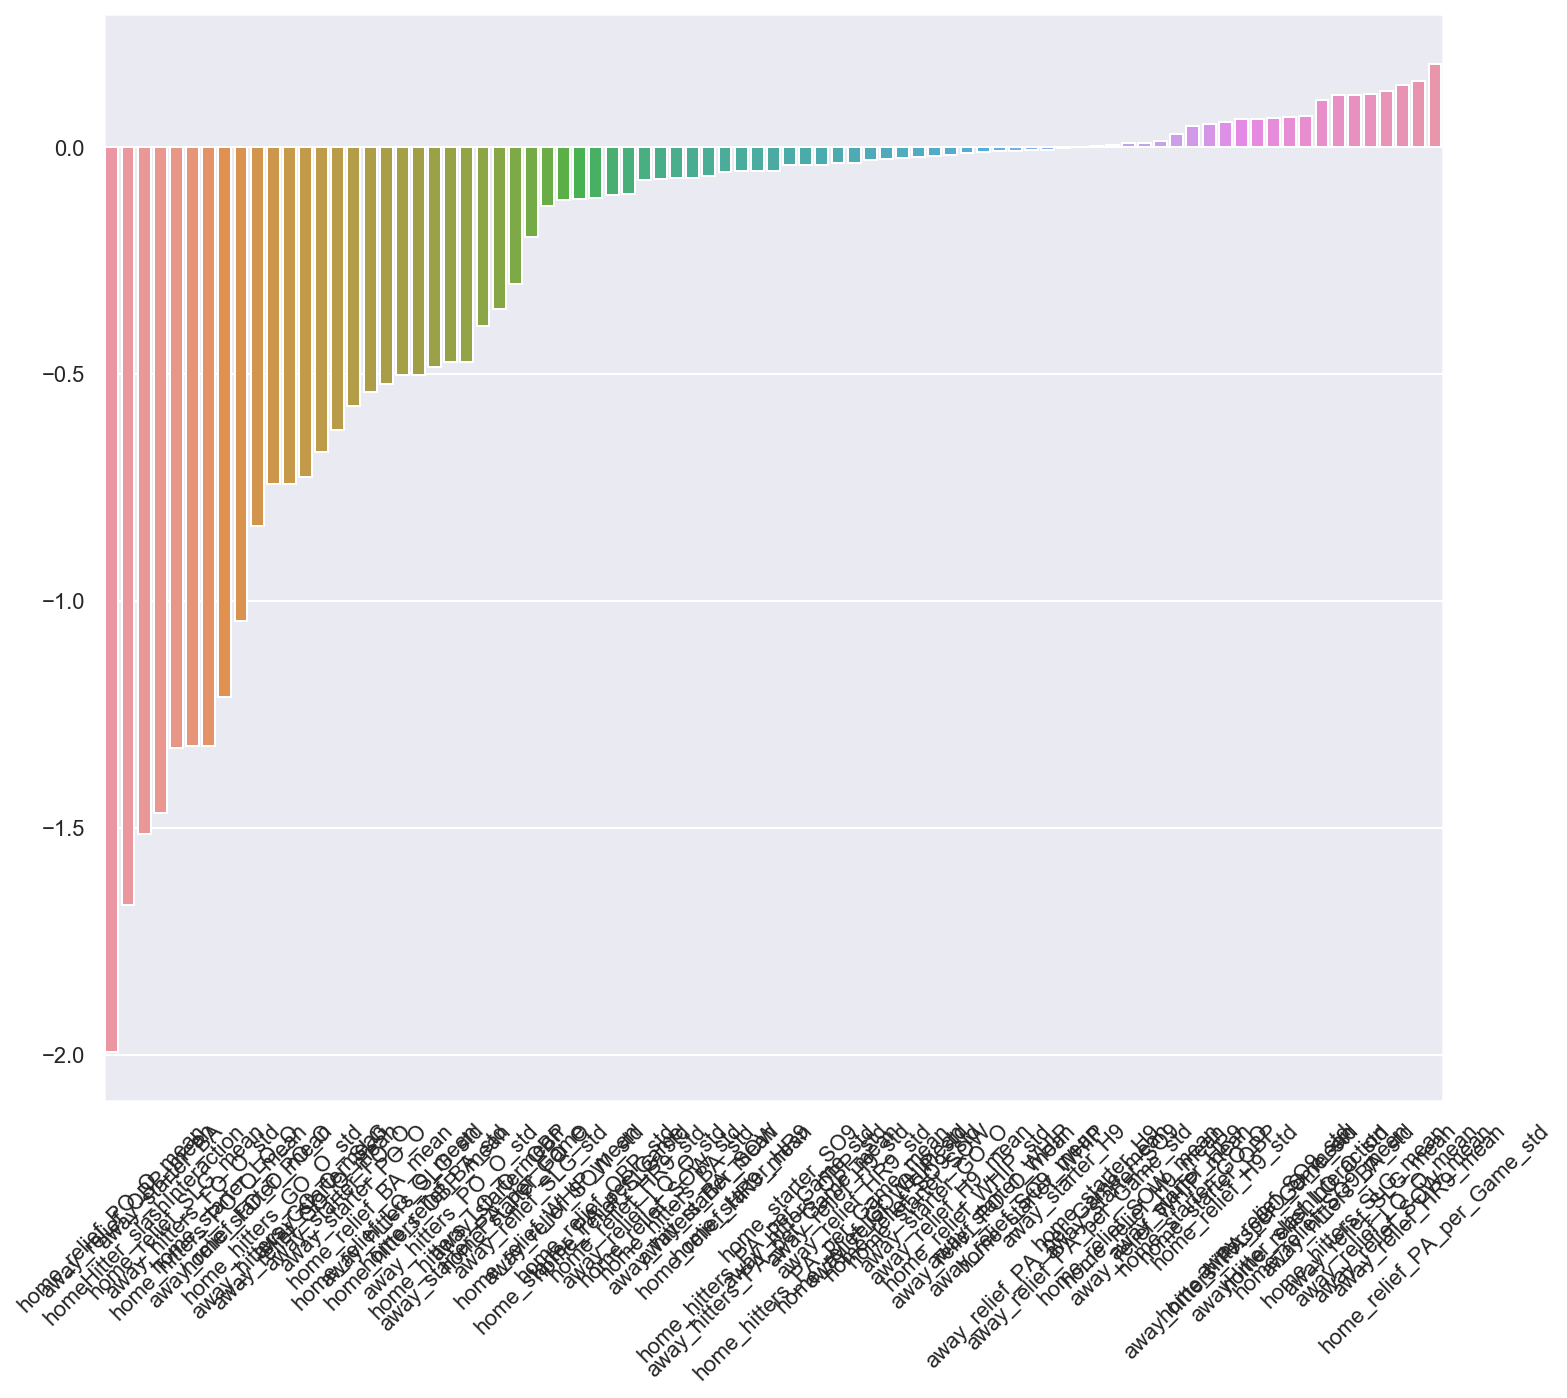

In [59]:
sns.barplot(x=[t[0] for t in lr_clf_feature_importance if t[1]<.2],y=[t[1] for t in lr_clf_feature_importance if t[1] < .2])
plt.xticks(rotation=45)

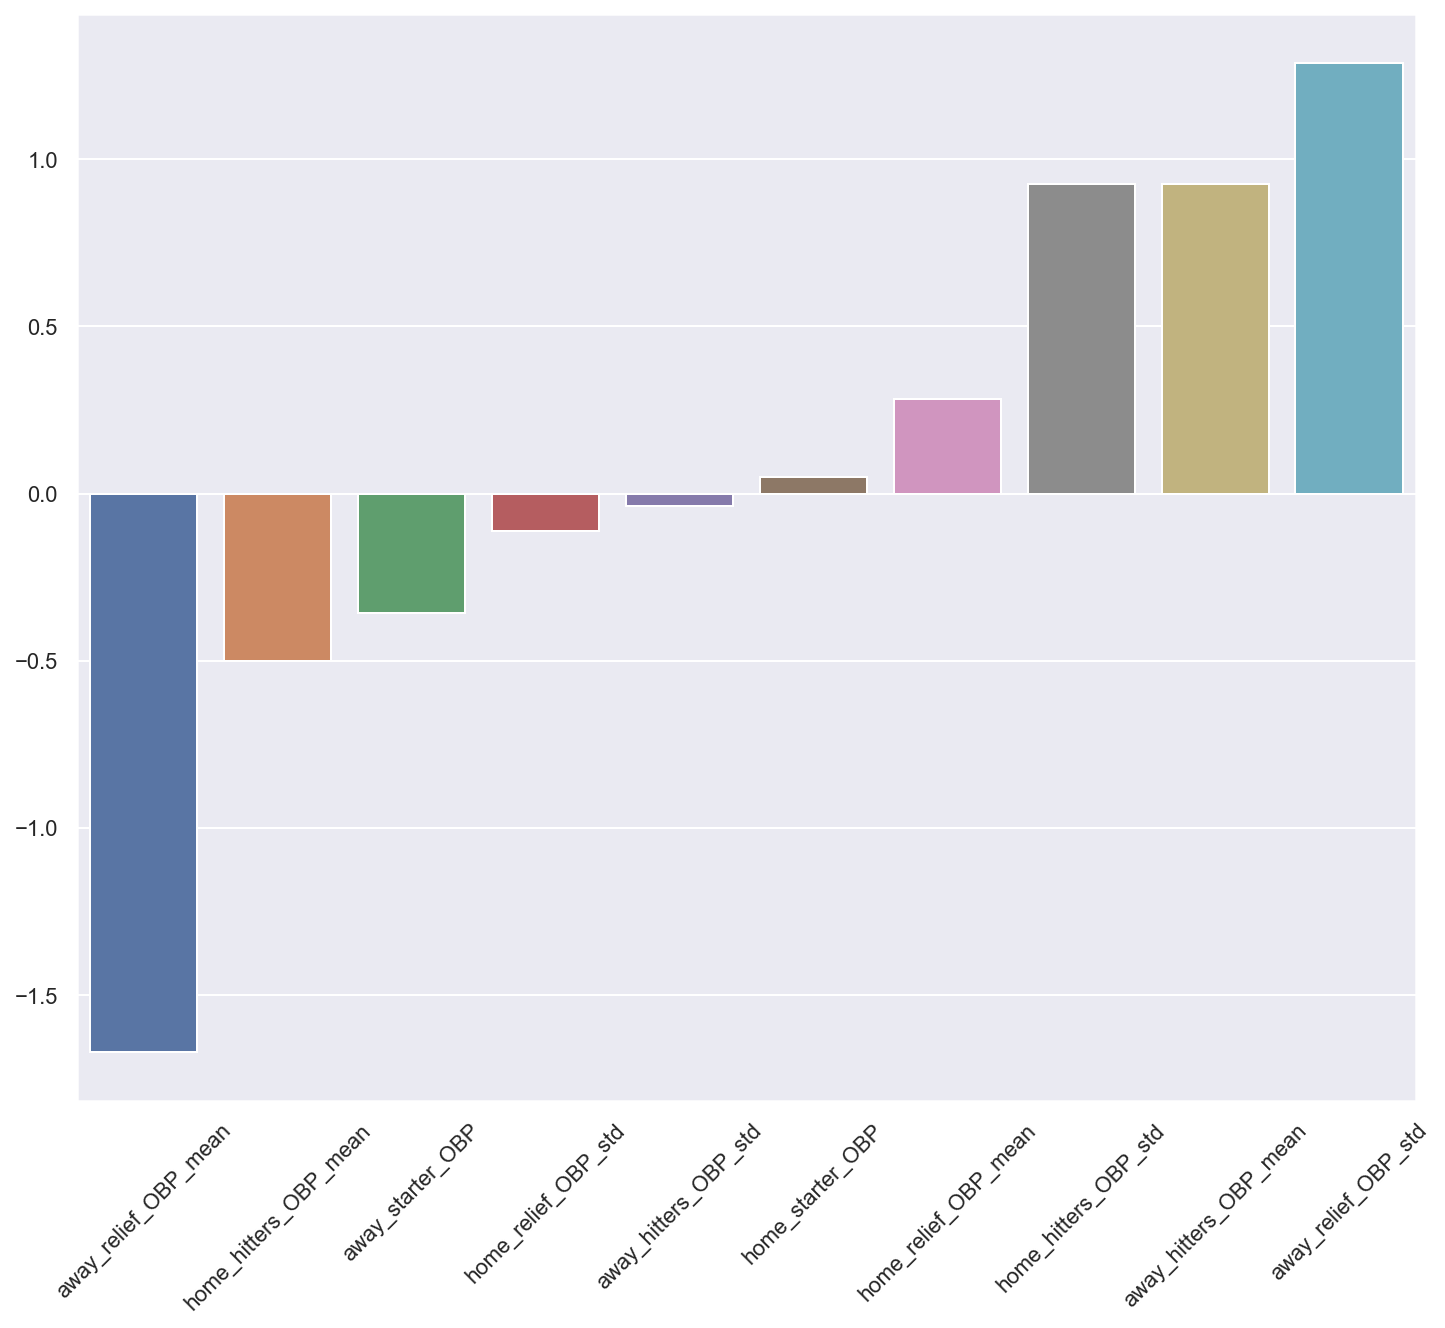

In [65]:
sns.barplot(x=[t[0] for t in lr_clf_feature_importance if 'OBP' in t[0]],y=[t[1] for t in lr_clf_feature_importance if 'OBP' in t[0]])
plt.xticks(rotation=45)
plt.savefig(image_dir+'lr_obp_fi.png')
plt.show()